# Capstone project!

## 1st project: Lifehackory

### Inventory/Stock prediction

> Synopsis: In a particular period, a certain few products would sell out really well. In anticipation of the increased sales, these products are stocked up to try and meet the demand. However when the goods came, the demand for these products would drop and take a long time to clear.

#### Problem statement 1: How much should I stock for the next 2 weeks - 1 month, with reference to current performance?

##### Mini Problem 1: Indexing of products
There is a problem with the indexing, mainly two of them:
1. A mix of current and discontinued products, and new products not yet in the market
2. One Qoo10 listing can represent multiple product types (different colour, size, shape etc)
3. Missing old data

Solution - Split into 3 groups: Old (discontinued), Current and New items, and for each category split them by Options.

##### Mini Problem 2: Can I model competitor's performance over time at what kind of confidence interval?
So I was told that in Qoo10 the number of reviews in a listing directly correlates with actual number of sales, with the ratio of 4:1 (Actual sales : No. Reviews). Reviews also come with datetime info plus user info (catch instances of users buying from different stores)

#### Problem statement 2: Can I predict my product performance with outside trends, and how much do they affect my sales?

#### Problem statement 3: How will my new products perform? Can I predict them based on performances of similar items and/or outside trends?

Current practice is to look at supplier data (also an e-commerce site)
Can I augment it with historical time-series data from similar products?

--------------------------------------------------------------------------------------------------------------------------

### Pricing

#### Problem statement 4: What is the optimum price I should put for each of my products?

#### Problem statement 5: What are the items that I can use to push for promotion, and how good are the returns?


### Space management

>2nd synopsis: Due to limited amount of storage space in the warehouse, we need to optimise the amount of goods being held in the warehouse, especially for bulky items. At the same time, we aim to maximise the amount of space available as much as possible.

>Currently there is no ready data available but can generate, except that it will take some time. Can tentatively limit to better performing items.

#### Problem statement 5: How much space should I allocate for each product at any one time?

Do in accordance to results from stock prediction

#### Problem statement 6: Can I use this data to optimize my profits?

### Customer management

#### Problem statement 7: Who are my best performing clientele?

What type of customers normally get what type of items, top grossing/top quantity/top repeated etc


In [199]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [200]:
qoo10_s17 = pd.read_excel('./lh qoo10 orders (2017).xlsx', sheetname='Singpost')
qoo10_q17 = pd.read_excel('./lh qoo10 orders (2017).xlsx', sheetname='Courier')

In [ ]:
qoo10_q17[qoo10_q17['Delivery company'] == 'Qxpress'].head()

In [202]:
print qoo10_s17.shape
print qoo10_q17.shape

(5709, 42)
(4857, 42)


In [203]:
#Take out redundant columns
#Only Shipping status with the values 'On Request' represent orders
qoo10_s17 = qoo10_s17[qoo10_s17['Shipping status']=='On Request']
qoo10_q17 = qoo10_q17[qoo10_q17['Shipping status']=='On Request']

In [204]:
print qoo10_s17.shape
print qoo10_q17.shape

(5356, 42)
(4514, 42)


In [205]:
qoo10_q17.columns

Index([u'Shipping status', u'Order no.', u'Cart no.', u'Delivery company',
       u'Tracking no.', u'Shipping date', u'Order date', u'Payment Complete',
       u'Desired Shipping Date', u'Estimated shipping date', u'Delivered date',
       u'Shipping Method', u'Item code', u'Item', u'Qty.', u'Options',
       u'Option Code', u'Gift', u'Recipient', u'Recipient(phonetic)',
       u'Recipient Phone number', u'Recipient mobile Phone number', u'Address',
       u'Postal code', u'Nation', u'Payment of shipping rate',
       u'Payment Nation', u'Currency', u'Payment', u'Sell Price', u'discount',
       u'Total Price', u'Settle Price', u'Customer', u'Customer(phonetic)',
       u'Memo to Seller', u'Customer phone number',
       u'Customer mobile phone number', u'Seller code', u'JAN code',
       u'Standard no.', u'Present'],
      dtype='object')

In [206]:
#check columns
print qoo10_q17.columns == qoo10_s17.columns
#yay

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [207]:
#Combine the two rows together
qoo10_17 = qoo10_s17.append(qoo10_q17, ignore_index=True)
qoo10_17.shape

(9870, 42)

In [208]:
#Yes there is a drop in the number of columns, where it contains absolutely no values at all.
print len(qoo10_17.columns)
print len(qoo10_17.dropna(axis=1, how='all').columns)

42
38


In [ ]:
#do it inplace
qoo10_17.dropna(axis=1, how='all', inplace=True)
qoo10_17.head()

In [210]:
qoo10_17['Delivery company'].value_counts()

Singpost normal mail    5888
Qxpress                 3518
POPStation               327
Others                   137
Name: Delivery company, dtype: int64

In [211]:
#Pull out columns again for referencing
qoo10_17.columns

Index([u'Shipping status', u'Order no.', u'Cart no.', u'Delivery company',
       u'Tracking no.', u'Shipping date', u'Order date', u'Payment Complete',
       u'Desired Shipping Date', u'Shipping Method', u'Item code', u'Item',
       u'Qty.', u'Options', u'Option Code', u'Gift', u'Recipient',
       u'Recipient(phonetic)', u'Recipient Phone number',
       u'Recipient mobile Phone number', u'Address', u'Postal code', u'Nation',
       u'Payment of shipping rate', u'Payment Nation', u'Currency', u'Payment',
       u'Sell Price', u'discount', u'Total Price', u'Settle Price',
       u'Customer', u'Customer(phonetic)', u'Memo to Seller',
       u'Customer phone number', u'Customer mobile phone number',
       u'Seller code', u'Present'],
      dtype='object')

In [212]:
#Take out Settle price = 0, these may be replacement orders
qoo10_17 = qoo10_17[~(qoo10_17['Settle Price']==0)]

In [213]:
#Time to drop columns
qoo10_17 = qoo10_17[['Order no.','Delivery company','Payment Complete','Item code','Item','Qty.','Options', 'Sell Price','discount']]

In [214]:
qoo10_17.columns

Index([u'Order no.', u'Delivery company', u'Payment Complete', u'Item code',
       u'Item', u'Qty.', u'Options', u'Sell Price', u'discount'],
      dtype='object')

In [215]:
#Find duplicated entries. Since order no. is unique, it is possible to filter using order no.
qoo10_17[qoo10_17.duplicated(subset='Order no.', keep=False)].sort_values('Order no.')

Order no.      Delivery company    Payment Complete    Item code  \
5692  202299480.0               Qxpress 2017-01-15 22:56:35  508767004.0   
5673  202299480.0               Qxpress 2017-01-15 22:56:35  508767004.0   
1796  214033195.0  Singpost normal mail 2017-04-23 21:19:17  495765958.0   
6883  214033195.0  Singpost normal mail 2017-04-23 21:19:17  495765958.0   
7492  218434989.0  Singpost normal mail 2017-06-12 11:48:28  513989352.0   
2478  218434989.0  Singpost normal mail 2017-06-12 11:48:28  513989352.0   
7515  218704109.0  Singpost normal mail 2017-06-14 17:57:22  503933243.0   
2514  218704109.0  Singpost normal mail 2017-06-14 17:57:22  503933243.0   
8768  230386615.0               Qxpress 2017-09-27 22:36:52  456547720.0   
8765  230386615.0               Qxpress 2017-09-27 22:36:52  456547720.0   
8824  230854060.0            POPStation 2017-10-03 10:25:00  481689686.0   
3509  230854060.0            POPStation 2017-10-03 10:25:00  481689686.0   
8826  230859617.0               Qxpress 2017-10-03 12:31:00  484265012.0   
3510  230859617.0               Qxpress 2017-10-03 12:31:00  484265012.0   
8827  230859618.0               Qxpress 2017-10-03 12:31:00  484265012.0   
3511  230859618.0               Qxpress 2017-10-03 12:31:00  484265012.0   
8828  230859619.0               Qxpress 2017-10-03 12:31:00  484265012.0   
3512  230859619.0               Qxpress 2017-10-03 12:31:00  484265012.0   
8829  230860873.0               Qxpress 2017-10-03 13:01:00  470480984.0   
3513  230860873.0               Qxpress 2017-10-03 13:01:00  470480984.0   
8830  230864992.0               Qxpress 2017-10-03 14:25:00  432351343.0   
3514  230864992.0               Qxpress 2017-10-03 14:25:00  432351343.0   
8831  230874225.0            POPStation 2017-10-03 17:36:00  542048405.0   
3515  230874225.0            POPStation 2017-10-03 17:36:00  542048405.0   
3516  230880110.0               Qxpress 2017-10-03 20:43:00  543391509.0   
8832  230880110.0               Qxpress 2017-10-03 20:43:00  543391509.0   
3517  230900089.0               Qxpress 2017-10-04 08:28:00  545172524.0   
8833  230900089.0               Qxpress 2017-10-04 08:28:00  545172524.0   
3518  230902804.0               Qxpress 2017-10-04 09:43:00  484265012.0   
8834  230902804.0               Qxpress 2017-10-04 09:43:00  484265012.0   
3520  230902805.0               Qxpress 2017-10-04 09:43:00  484265012.0   
8836  230902805.0               Qxpress 2017-10-04 09:43:00  484265012.0   
3519  230902806.0               Qxpress 2017-10-04 09:43:00  484265012.0   
8835  230902806.0               Qxpress 2017-10-04 09:43:00  484265012.0   
3521  230905156.0               Qxpress 2017-10-04 10:15:00  491452496.0   
8837  230905156.0               Qxpress 2017-10-04 10:15:00  491452496.0   
9206  234135647.0  Singpost normal mail 2017-11-05 18:15:56  495765958.0   
4684  234135647.0  Singpost normal mail 2017-11-05 18:15:56  495765958.0   
9313  235773470.0               Qxpress 2017-11-12 00:39:21  536286815.0   
9823  235773470.0               Qxpress 2017-11-12 00:39:21  536286815.0   
4842  236278669.0  Singpost normal mail 2017-11-14 08:36:17  503933243.0   
9365  236278669.0  Singpost normal mail 2017-11-14 08:36:17  503933243.0   
4843  236279628.0  Singpost normal mail 2017-11-14 09:10:36  436360301.0   
9369  236279628.0  Singpost normal mail 2017-11-14 09:10:36  436360301.0   
4956  237696237.0  Singpost normal mail 2017-11-23 14:10:58  458638283.0   
9485  237696237.0  Singpost normal mail 2017-11-23 14:10:58  458638283.0   
9720  238951333.0               Qxpress 2017-12-06 11:34:08  502416689.0   
9722  238951333.0               Qxpress 2017-12-06 11:34:08  502416689.0   

                                                   Item Qty.  \
5692  â˜… Kids Soft Cushion Toilet Seat â˜… Potty Tr...    1   
5673  â˜… Kids Soft Cushion Toilet Seat â˜… Potty Tr...    1   
1796  â˜… Swivel-Lid Dustbin â˜… Excellent Quality! ...    1   
6883  â˜… Swivel-Lid Dustbi

In [216]:
qoo10_17[qoo10_17.duplicated(subset='Order no.', keep=False)].index

Int64Index([1796, 2478, 2514, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516,
            3517, 3518, 3519, 3520, 3521, 4684, 4842, 4843, 4956, 5673, 5692,
            6883, 7492, 7515, 8765, 8768, 8824, 8826, 8827, 8828, 8829, 8830,
            8831, 8832, 8833, 8834, 8835, 8836, 8837, 9206, 9313, 9365, 9369,
            9485, 9720, 9722, 9823],
           dtype='int64')

In [217]:
#Drop using index
qoo10_17.drop(qoo10_17[qoo10_17.duplicated(subset='Order no.', keep=False)].index, inplace=True)
qoo10_17[qoo10_17.duplicated(subset='Order no.', keep=False)].sort_values('Order no.')

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []

In [218]:
for col in qoo10_17.columns:
    print qoo10_17[qoo10_17[col].isnull()]
#No null values! good

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount]
Index: []
Empty DataFrame
Columns: [Order no., Deli

In [219]:
qoo10_17.dtypes

Order no.                  float64
Delivery company            object
Payment Complete    datetime64[ns]
Item code                  float64
Item                        object
Qty.                        object
Options                     object
Sell Price                  object
discount                   float64
dtype: object

In [220]:
qoo10_17['Qty.'].value_counts()
#What the hell is ff


1       8289
2       1131
3        190
4        111
5         45
6         15
8          7
10         6
7          4
9          3
ƒƒ         1
35.0       1
18         1
15         1
13.0       1
12.0       1
Name: Qty., dtype: int64

In [221]:
#Traditional searching using == does not work for ƒƒ, so...
qoo10_17[qoo10_17['Qty.'] >20]
#Found it!

Order no.      Delivery company    Payment Complete    Item code  \
3590  226018084.0  Singpost normal mail 2017-08-20 00:38:22  462464464.0   
6462  209584830.0               Qxpress 2017-03-16 02:27:31  435414087.0   

                                                   Item Qty.  \
3590  â˜… Extendable Kitchen Organizer Rack â˜… Full...   ƒƒ   
6462  â˜… Stainless Steel Clothes Hanger with Trouse...   35   

                                         Options Sell Price  discount  
3590     Type:Extendable Kitchen Organizer Rack        11.6       0.2  
6462  Type:Stainless Steel Clothes Hanger (1pc)         2.1       7.0

In [222]:
qoo10_17.drop(3590, inplace=True)
qoo10_17['Qty.'].value_counts()

1.0     8289
2.0     1131
3.0      190
4.0      111
5.0       45
6.0       15
8.0        7
10.0       6
7.0        4
9.0        3
35.0       1
18.0       1
15.0       1
13.0       1
12.0       1
Name: Qty., dtype: int64

## Well guess what

I also have 2016 data!
More rows for me

In [223]:
qoo10_s16 = pd.read_excel('./LH Qoo10 Orders (2014 - 2016).xls', sheetname='Singpost')
qoo10_q16 = pd.read_excel('./LH Qoo10 Orders (2014 - 2016).xls', sheetname='Courier')

In [224]:
#Take out redundant columns
#Only Shipping status with the values 'On Request' represent orders
qoo10_s16 = qoo10_s16[qoo10_s16['Shipping status']=='On Request']
qoo10_q16 = qoo10_q16[qoo10_q16['Shipping status']=='On Request']

In [225]:
print qoo10_s16.shape
print qoo10_q16.shape

(4559, 42)
(8062, 42)


In [226]:
qoo10_16 = qoo10_s16.append(qoo10_q16, ignore_index=True)
qoo10_16 = qoo10_16[['Order no.','Delivery company','Payment Complete','Item code','Item','Qty.','Options','Sell Price','discount']]

In [227]:
qoo10_16.drop(qoo10_16[qoo10_16.duplicated(subset='Order no.', keep=False)].index, inplace=True)

In [228]:
qoo10_16.head()

Order no.      Delivery company       Payment Complete    Item code  \
0  46912738.0  Singpost normal mail  Sep 22, 2014 21:32:09  419731390.0   
1  46916402.0  Singpost normal mail  Sep 22, 2014 21:54:32  419731390.0   
2  46921095.0  Singpost normal mail  Sep 22, 2014 23:31:41  419731390.0   
3  46987317.0  Singpost normal mail  Sep 24, 2014 22:57:16  419731390.0   
4  47001604.0  Singpost normal mail  Sep 25, 2014 12:45:03  419731390.0   

                                                Item  Qty.  \
0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
1  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
2  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
3  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
4  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   

                                             Options  Sell Price  discount  
0  Model:2: Candy Solid Back(+S$1) / Screen Prote...         9.0       0.0  
1  Model:8: Graphic Series(+S$1.90) / Screen Prot...         9.0       0.0  
2  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0  
3  Model:5: Royalty Series(+S$2.90) / Screen Prot...         9.0       0.0  
4  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0

In [229]:
qoo10_16['Qty.'].value_counts()
#Safe

1.0     10710
2.0      1368
3.0       284
4.0       141
5.0        39
6.0        35
10.0        9
7.0         8
9.0         3
8.0         3
20.0        3
15.0        3
30.0        1
24.0        1
16.0        1
33.0        1
14.0        1
Name: Qty., dtype: int64

In [230]:
def conv_d(x):
    x = str(x)
    match = re.match('[^0-9]{3}.\d.+',str(x))
    if match:
        return dt.datetime.strptime(match.group(0), '%b %d, %Y %H:%M:%S').strftime('%Y-%m-%d')
    else:
        match = re.match('[0-9].+',str(x))
        if match:
            return dt.datetime.strptime(match.group(0), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
        else:
            return None


qoo10_16['Date'] = qoo10_16['Payment Complete'].apply(conv_d)
qoo10_16.head()

Order no.      Delivery company       Payment Complete    Item code  \
0  46912738.0  Singpost normal mail  Sep 22, 2014 21:32:09  419731390.0   
1  46916402.0  Singpost normal mail  Sep 22, 2014 21:54:32  419731390.0   
2  46921095.0  Singpost normal mail  Sep 22, 2014 23:31:41  419731390.0   
3  46987317.0  Singpost normal mail  Sep 24, 2014 22:57:16  419731390.0   
4  47001604.0  Singpost normal mail  Sep 25, 2014 12:45:03  419731390.0   

                                                Item  Qty.  \
0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
1  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
2  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
3  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
4  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   

                                             Options  Sell Price  discount  \
0  Model:2: Candy Solid Back(+S$1) / Screen Prote...         9.0       0.0   
1  Model:8: Graphic Series(+S$1.90) / Screen Prot...         9.0       0.0   
2  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0   
3  Model:5: Royalty Series(+S$2.90) / Screen Prot...         9.0       0.0   
4  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0   

         Date  
0  2014-09-22  
1  2014-09-22  
2  2014-09-22  
3  2014-09-24  
4  2014-09-25

In [231]:
qoo10_16[qoo10_16['Date'].isnull()]

Order no.      Delivery company Payment Complete    Item code  \
1070  162178164.0  Singpost normal mail              NaN  443182338.0   

                                                   Item  Qty.  \
1070  â˜… Mosquito Trap UV Lamp Fan â˜… [EFFECTIVE] ...   1.0   

                         Options  Sell Price  discount  Date  
1070  Type:Mosquito Trap UV Fan         27.1       1.2  None

In [232]:
def conv_t(x):
    x = str(x)
    match = re.match('[^0-9]{3}.\d.+',str(x))
    if match:
        return dt.datetime.strptime(match.group(0), '%b %d, %Y %H:%M:%S').strftime('%H:%M:%S')
    else:
        match = re.match('[0-9].+',str(x))
        if match:
            return dt.datetime.strptime(match.group(0), '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S')
        else:
            return None

qoo10_16['Time'] = qoo10_16['Payment Complete'].apply(conv_t)
qoo10_16.head()

Order no.      Delivery company       Payment Complete    Item code  \
0  46912738.0  Singpost normal mail  Sep 22, 2014 21:32:09  419731390.0   
1  46916402.0  Singpost normal mail  Sep 22, 2014 21:54:32  419731390.0   
2  46921095.0  Singpost normal mail  Sep 22, 2014 23:31:41  419731390.0   
3  46987317.0  Singpost normal mail  Sep 24, 2014 22:57:16  419731390.0   
4  47001604.0  Singpost normal mail  Sep 25, 2014 12:45:03  419731390.0   

                                                Item  Qty.  \
0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
1  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
2  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
3  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   
4  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1.0   

                                             Options  Sell Price  discount  \
0  Model:2: Candy Solid Back(+S$1) / Screen Prote...         9.0       0.0   
1  Model:8: Graphic Series(+S$1.90) / Screen Prot...         9.0       0.0   
2  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0   
3  Model:5: Royalty Series(+S$2.90) / Screen Prot...         9.0       0.0   
4  Model:7: Vintage Series(+S$3.90) / Screen Prot...         9.0       0.0   

         Date      Time  
0  2014-09-22  21:32:09  
1  2014-09-22  21:54:32  
2  2014-09-22  23:31:41  
3  2014-09-24  22:57:16  
4  2014-09-25  12:45:03

In [233]:
qoo10_16[qoo10_16['Time'].isnull()]

Order no.      Delivery company Payment Complete    Item code  \
1070  162178164.0  Singpost normal mail              NaN  443182338.0   

                                                   Item  Qty.  \
1070  â˜… Mosquito Trap UV Lamp Fan â˜… [EFFECTIVE] ...   1.0   

                         Options  Sell Price  discount  Date  Time  
1070  Type:Mosquito Trap UV Fan         27.1       1.2  None  None

In [234]:
for col in qoo10_16.columns:
    print col
    print qoo10_16[qoo10_16[col].isnull()]
    print "_____________________________________________________________________________________________"

Order no.
Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount, Date, Time]
Index: []
_____________________________________________________________________________________________
Delivery company
        Order no. Delivery company       Payment Complete    Item code  \
4086  109565749.0              NaN  Nov 26, 2016 19:20:03  487458376.0   

                                                   Item  Qty.  \
4086  ★ Punch Pliers ★ Punch Belt Holes / Fix Snaps ...   1.0   

                 Options  Sell Price  discount        Date      Time  
4086  Type:Punch Pliers          7.6       0.0  2016-11-26  19:20:03  
_____________________________________________________________________________________________
Payment Complete
        Order no.      Delivery company Payment Complete    Item code  \
1070  162178164.0  Singpost normal mail              NaN  443182338.0   

                                                  

In [235]:
#Oh just one row, just drop it lah
qoo10_16.drop(1070, inplace=True)
qoo10_16[qoo10_16['Payment Complete'].isnull()]
#Done

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount, Date, Time]
Index: []

In [236]:
#perf_2016 = qoo10_16.groupby(['Item code','Options'])['Item','Qty.'].apply(np.sum).sort_values('Qty.', ascending=False)

In [237]:
#perf_2017 = qoo10_17.groupby(['Item code','Options'])['Item','Qty.'].apply(np.sum).sort_values('Qty.', ascending=False)

In [238]:
qoo10_17['Date'] = qoo10_17['Payment Complete'].apply(conv_d)
qoo10_17['Time'] = qoo10_17['Payment Complete'].apply(conv_t)

In [239]:
qoo10_17[qoo10_17['Date'].isnull()]

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount, Date, Time]
Index: []

In [240]:
qoo10_17[qoo10_17['Time'].isnull()]

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, Qty., Options, Sell Price, discount, Date, Time]
Index: []

In [241]:
qoo10_17.head()

Order no.      Delivery company    Payment Complete    Item code  \
0  200594402.0  Singpost normal mail 2017-01-01 02:18:01  425937308.0   
1  200596994.0  Singpost normal mail 2017-01-01 05:14:34  441069153.0   
2  200598253.0  Singpost normal mail 2017-01-01 08:47:11  507747453.0   
3  200605099.0  Singpost normal mail 2017-01-01 10:04:41  467163347.0   
4  200615242.0  Singpost normal mail 2017-01-01 10:59:45  458630367.0   

                                                Item Qty.  \
0  â˜… Classic Bathroom Racks â˜… 5 Types! Modern...    1   
1  â˜… Clip-on Car Dustbin â˜… Mini Trash Rubbish...    1   
2  â˜… Sun Protection Ice Sleeves â˜… Cooling Eff...    1   
3  â˜… Multi-Pocket Hanging Storage â˜… Save Prec...    2   
4  â˜… Colourful Disposable Kitchen Towel â˜… 50p...    1   

                                Options Sell Price  discount        Date  \
0  Type:40cm Single Tier Rack(+S$1.90)        15.1       0.2  2017-01-01   
1                          Color:Black         7.7       0.2  2017-01-01   
2                           Color:Nude         4.6       0.2  2017-01-01   
3       Size:Small / Type:Animal Beige         8.1       0.4  2017-01-01   
4       Color:Green (50 pcs x 2 rolls)         3.7       0.2  2017-01-01   

       Time  
0  02:18:01  
1  05:14:34  
2  08:47:11  
3  10:04:41  
4  10:59:45

In [242]:
qoo10_all = qoo10_16.append(qoo10_17, ignore_index=True)

In [243]:
qoo10_all.rename(columns={'Qty.':'qty'}, inplace=True)

In [244]:
qoo10_all.shape

(22416, 11)

In [245]:
qoo10_all.head()

Order no.      Delivery company       Payment Complete    Item code  \
0  46912738.0  Singpost normal mail  Sep 22, 2014 21:32:09  419731390.0   
1  46916402.0  Singpost normal mail  Sep 22, 2014 21:54:32  419731390.0   
2  46921095.0  Singpost normal mail  Sep 22, 2014 23:31:41  419731390.0   
3  46987317.0  Singpost normal mail  Sep 24, 2014 22:57:16  419731390.0   
4  47001604.0  Singpost normal mail  Sep 25, 2014 12:45:03  419731390.0   

                                                Item qty  \
0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
1  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
2  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
3  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
4  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   

                                             Options Sell Price  discount  \
0  Model:2: Candy Solid Back(+S$1) / Screen Prote...          9       0.0   
1  Model:8: Graphic Series(+S$1.90) / Screen Prot...          9       0.0   
2  Model:7: Vintage Series(+S$3.90) / Screen Prot...          9       0.0   
3  Model:5: Royalty Series(+S$2.90) / Screen Prot...          9       0.0   
4  Model:7: Vintage Series(+S$3.90) / Screen Prot...          9       0.0   

         Date      Time  
0  2014-09-22  21:32:09  
1  2014-09-22  21:54:32  
2  2014-09-22  23:31:41  
3  2014-09-24  22:57:16  
4  2014-09-25  12:45:03

In [246]:
qoo10_sort = qoo10_all[['Date','Time','Item code','Options','qty']].sort_values(['Item code','Date'])

In [247]:
qoo10_all[['Item code','Item','Options']]
    

Item code                                               Item  \
0      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
1      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
2      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
3      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
4      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
5      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
6      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
7      419731390.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
8      420029971.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
9      420029971.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
10     420029971.0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   
11     420029971.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
12     420029971.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
13     420029971.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
14     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
15     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
16     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
17     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
18     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
19     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
20     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
21     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
22     420841071.0  World Map Poster - Around the Globe - Local Se...   
23     420841071.0  World Map Poster - Around the Globe - Local Se...   
24     420841071.0  SG Seller Ready Stock - World Map Poster - Aro...   
25     419731390.0  â˜… FREE Screen Protector â˜… Classy n Cute iP...   
26     420841071.0  SG Seller Ready Stock - World Map Poster - Aro...   
27     420841071.0  SG Seller Ready Stock - World Map Poster - Aro...   
28     420841071.0  SG Seller Ready Stock - World Map Poster - Aro...   
29     420841071.0  SG Seller Ready Stock - World Map Poster - Aro...   
...            ...                                                ...   
22386  486822701.0  â˜… Drawer Compartment Organizer â˜… Stationer...   
22387  436716506.0  [Multi-color] â˜… Anti-Slip Cooling Mat! â˜… M...   
22388  458638283.0  â˜… 4-Slot Horizontal Document Tray â˜… Home O...   
22389  490648942.0  â˜… Stainless Steel Microwave Space-Saving Rac...   
22390  458638283.0  â˜… 4-Slot Horizontal Document Tray â˜… Home O...   
22391  483701119.0  â˜… Transparent 3-Layer Storage Case â˜… Multi...   
22392  543391509.0  â˜… Lazy Sofa â˜… 7 Designs! Adjustable Comfor...   
22393  545167472.0  â˜… Trolley Cart with Side Pocket â˜… PU Wheel...   
22394  427748529.0  â¤ Double-Sided Jewellery Organizer with Neck...   
22395  491467047.0  â˜… Stainless Steel Pedal Bin â˜… Silent Flip ...   
22396  498006789.0  â˜… Foldable Canvas Laundry Bag â˜… Coloured C...   
22397  510444807.0  â˜… Inflatable Mattress Bed â˜… Free Electric ...   
22398  510237558.0  â˜… Aluminium Phone Holder â˜… For Mobile Phon...   
22399  427251228.0  â˜… Wooden Stationery Organizer â˜… Natural Wo...   
22400  490648942.0  â˜… Stainless Steel Microwave Space-Saving Rac...   
22401  537557585.0  â˜… Ceramic Utensil Holder â˜… With Wooden Sta...   
22402  509033184.0  â˜… Fitness Mat â˜… With Bag And Rope Tie! For...   
22403  514972983.0  â˜… Vintage Double Zip Hand Bag / Sling Bag â˜...   
22404  510237558.0  â˜… Aluminium Phone Holder â˜… For Mobile Phon...   
22405  490648942.0  â˜… Stainless Steel Microwave Space-Saving Rac...   
22406  495765958.0  â˜… Swivel-Lid Dustbin â˜… Excellent Quality! ...   
22407  495765958.0  â˜… Swivel-Lid Dustbin â˜… Excellent Quality! ...   
22408  509031567.0  â–¶  Dart Board â—€ 12-inch / 15-inch Dartboar.

In [248]:
#writer = pd.ExcelWriter('Qoo10_all.xlsx', engine='xlsxwriter')
#qoo10_sort.to_excel(writer, sheet_name='Sheet1')
#writer.save()

## Reference sheet

In [249]:
ref = pd.read_csv('./reference.csv', header=1)
ref.head()

Category Name Qoo10 Item Code                         Qoo10 Options  \
0  Bathroom & Toilet       425937308      Type:32cm Single Tier Rack(-S$2)   
1  Bathroom & Toilet       425937308   Type:40cm Single Tier Rack(+S$1.90)   
2  Bathroom & Toilet       425937308   Type:40cm Double Tier Rack(+S$7.90)   
3  Bathroom & Toilet       425937308   Type:50cm Single Tier Rack(+S$4.90)   
4  Bathroom & Toilet       425937308  Type:50cm Double Tier Rack(+S$14.90)   

              Master List Item Name         Type  Size Colour       Barcode  \
0  Bathroom Rack - 32cm Single Tier  Single Tier  32cm    NaN  425937308S32   
1  Bathroom Rack - 40cm Single Tier  Single Tier  40cm    NaN  425937308D40   
2  Bathroom Rack - 40cm Double Tier  Double Tier  40cm    NaN  425937308S40   
3  Bathroom Rack - 50cm Single Tier  Single Tier  50cm    NaN           NaN   
4  Bathroom Rack - 50cm Double Tier  Double Tier  50cm    NaN  425937308D50   

   New Item No   Item No                                    Qoo10 Item Name  
0   10000001.0  10000010  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
1   10000002.0  10000012  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
2   10000003.0  10000011  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
3   10000004.0       NaN  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
4   10000005.0  10000013  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...

## Converting number entries to int value - try 2017

In [250]:
qoo10_17['Item code']=qoo10_17['Item code'].astype(int)
qoo10_17['Order no.']=qoo10_17['Order no.'].astype(int)
qoo10_17.dtypes

Order no.                    int32
Delivery company            object
Payment Complete    datetime64[ns]
Item code                    int32
Item                        object
Qty.                        object
Options                     object
Sell Price                  object
discount                   float64
Date                        object
Time                        object
dtype: object

In [251]:
qoo10_17.head()

Order no.      Delivery company    Payment Complete  Item code  \
0  200594402  Singpost normal mail 2017-01-01 02:18:01  425937308   
1  200596994  Singpost normal mail 2017-01-01 05:14:34  441069153   
2  200598253  Singpost normal mail 2017-01-01 08:47:11  507747453   
3  200605099  Singpost normal mail 2017-01-01 10:04:41  467163347   
4  200615242  Singpost normal mail 2017-01-01 10:59:45  458630367   

                                                Item Qty.  \
0  â˜… Classic Bathroom Racks â˜… 5 Types! Modern...    1   
1  â˜… Clip-on Car Dustbin â˜… Mini Trash Rubbish...    1   
2  â˜… Sun Protection Ice Sleeves â˜… Cooling Eff...    1   
3  â˜… Multi-Pocket Hanging Storage â˜… Save Prec...    2   
4  â˜… Colourful Disposable Kitchen Towel â˜… 50p...    1   

                                Options Sell Price  discount        Date  \
0  Type:40cm Single Tier Rack(+S$1.90)        15.1       0.2  2017-01-01   
1                          Color:Black         7.7       0.2  2017-01-01   
2                           Color:Nude         4.6       0.2  2017-01-01   
3       Size:Small / Type:Animal Beige         8.1       0.4  2017-01-01   
4       Color:Green (50 pcs x 2 rolls)         3.7       0.2  2017-01-01   

       Time  
0  02:18:01  
1  05:14:34  
2  08:47:11  
3  10:04:41  
4  10:59:45

In [252]:
#FINALLY I GOT IT
x = 425937308
ref[ref['Qoo10 Item Code'].isin([str(x)])]

Category Name Qoo10 Item Code  \
0  Bathroom & Toilet       425937308   
1  Bathroom & Toilet       425937308   
2  Bathroom & Toilet       425937308   
3  Bathroom & Toilet       425937308   
4  Bathroom & Toilet       425937308   
5  Bathroom & Toilet       425937308   
6  Bathroom & Toilet       425937308   

                                    Qoo10 Options  \
0                Type:32cm Single Tier Rack(-S$2)   
1             Type:40cm Single Tier Rack(+S$1.90)   
2             Type:40cm Double Tier Rack(+S$7.90)   
3             Type:50cm Single Tier Rack(+S$4.90)   
4            Type:50cm Double Tier Rack(+S$14.90)   
5  Type:V-Shaped Corner Double Tier Rack(+S$4.90)   
6                                             NaN   

                  Master List Item Name             Type  Size Colour  \
0      Bathroom Rack - 32cm Single Tier      Single Tier  32cm    NaN   
1      Bathroom Rack - 40cm Single Tier      Single Tier  40cm    NaN   
2      Bathroom Rack - 40cm Double Tier      Double Tier  40cm    NaN   
3      Bathroom Rack - 50cm Single Tier      Single Tier  50cm    NaN   
4      Bathroom Rack - 50cm Double Tier      Double Tier  50cm    NaN   
5  Bathroom Rack - V-shaped Double Tier  V-shaped Double   NaN    NaN   
6  Bathroom Rack - V-shaped Triple Tier  V-shaped Triple   NaN    NaN   

        Barcode  New Item No   Item No  \
0  425937308S32   10000001.0  10000010   
1  425937308D40   10000002.0  10000012   
2  425937308S40   10000003.0  10000011   
3           NaN   10000004.0       NaN   
4  425937308D50   10000005.0  10000013   
5   425937308VD   10000006.0  10000014   
6   425937308VT   10000007.0  10000015   

                                     Qoo10 Item Name  
0  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
1  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
2  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
3  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
4  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
5  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...  
6  [BL]★ Classic Bathroom Racks ★ 5 Types! Modern...

In [253]:
ref.dtypes

Category Name             object
Qoo10 Item Code           object
Qoo10 Options             object
Master List Item Name     object
Type                      object
Size                      object
Colour                    object
Barcode                   object
New Item No              float64
Item No                   object
Qoo10 Item Name           object
dtype: object

In [254]:
qoo10_all.dtypes

Order no.           float64
Delivery company     object
Payment Complete     object
Item code           float64
Item                 object
qty                  object
Options              object
Sell Price           object
discount            float64
Date                 object
Time                 object
dtype: object

In [255]:
qoo10_all['Item code'] = qoo10_all['Item code'].astype(int)
qoo10_all['comb'] = qoo10_all['Item code'].astype(str)+' '+qoo10_all['Options']
ref['comb'] = ref['Qoo10 Item Code']+' '+ref['Qoo10 Options']

In [256]:
qoo10_all['comb'].head()

0    419731390 Model:2: Candy Solid Back(+S$1) / Sc...
1    419731390 Model:8: Graphic Series(+S$1.90) / S...
2    419731390 Model:7: Vintage Series(+S$3.90) / S...
3    419731390 Model:5: Royalty Series(+S$2.90) / S...
4    419731390 Model:7: Vintage Series(+S$3.90) / S...
Name: comb, dtype: object

In [257]:
ref['comb'].head()

0        425937308 Type:32cm Single Tier Rack(-S$2)
1     425937308 Type:40cm Single Tier Rack(+S$1.90)
2     425937308 Type:40cm Double Tier Rack(+S$7.90)
3     425937308 Type:50cm Single Tier Rack(+S$4.90)
4    425937308 Type:50cm Double Tier Rack(+S$14.90)
Name: comb, dtype: object

In [258]:
qoo10_all[qoo10_all['comb'].isin(ref['comb'])]
#Fail

Order no.      Delivery company       Payment Complete  Item code  \
4615   146168594.0               Qxpress  May 31, 2015 19:32:03  427418532   
7569   163296520.0               Qxpress    2016-02-14 01:54:36  444538033   
7570   163296519.0               Qxpress    2016-02-14 01:54:36  444538033   
17788  238953169.0  Singpost normal mail    2017-12-06 12:15:05  496813547   

                                                    Item qty  \
4615   â˜… Picnic Baskets â˜… Natural Brown / White /...   1   
7569   â˜…  Desktop Organizer Cube â˜… Table Tabletop...   1   
7570   â˜…  Desktop Organizer Cube â˜… Table Tabletop...   1   
17788  ★ Car Hanging Hooks ★ More Storage Space at Ba...   1   

                                       Options Sell Price  discount  \
4615   Type:L1 - Natural Brown Large(+S$17.90)       26.1       0.2   
7569               Type:Desktop Organizer Cube       15.1       1.2   
7570               Type:Desktop Organizer Cube       15.1       1.2   
17788                   Type:Car Hanging Hooks        3.1       0.2   

             Date      Time                                               comb  
4615   2015-05-31  19:32:03  427418532 Type:L1 - Natural Brown Large(+S$17.90)  
7569   2016-02-14  01:54:36              444538033 Type:Desktop Organizer Cube  
7570   2016-02-14  01:54:36              444538033 Type:Desktop Organizer Cube  
17788  2017-12-06  12:15:05                   496813547 Type:Car Hanging Hooks

## Visualise monthly data of Desktop Organizer

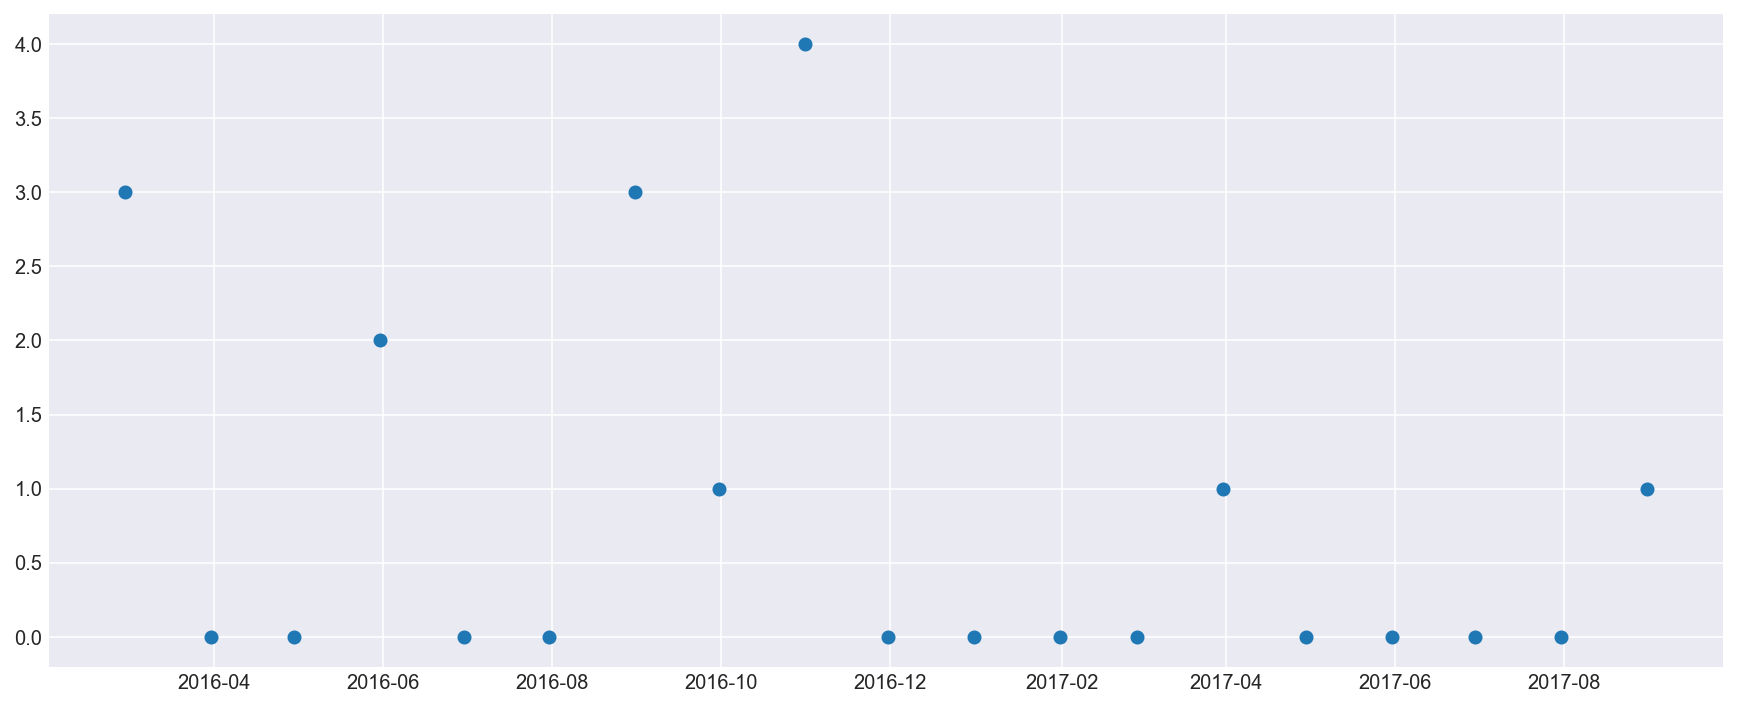

In [259]:
data = qoo10_all[qoo10_all['Item code']==444538033][['Date','qty']]
data['Date'] = pd.to_datetime(data['Date'])
data['qty'] = pd.to_numeric(data['qty'])
data.index = data['Date']
data = data.resample('M').sum().fillna(0)
plt.figure(figsize=(15,6))
plt.plot(data['qty'], marker='o', linestyle='None')

## Memory foam performance across time per hour

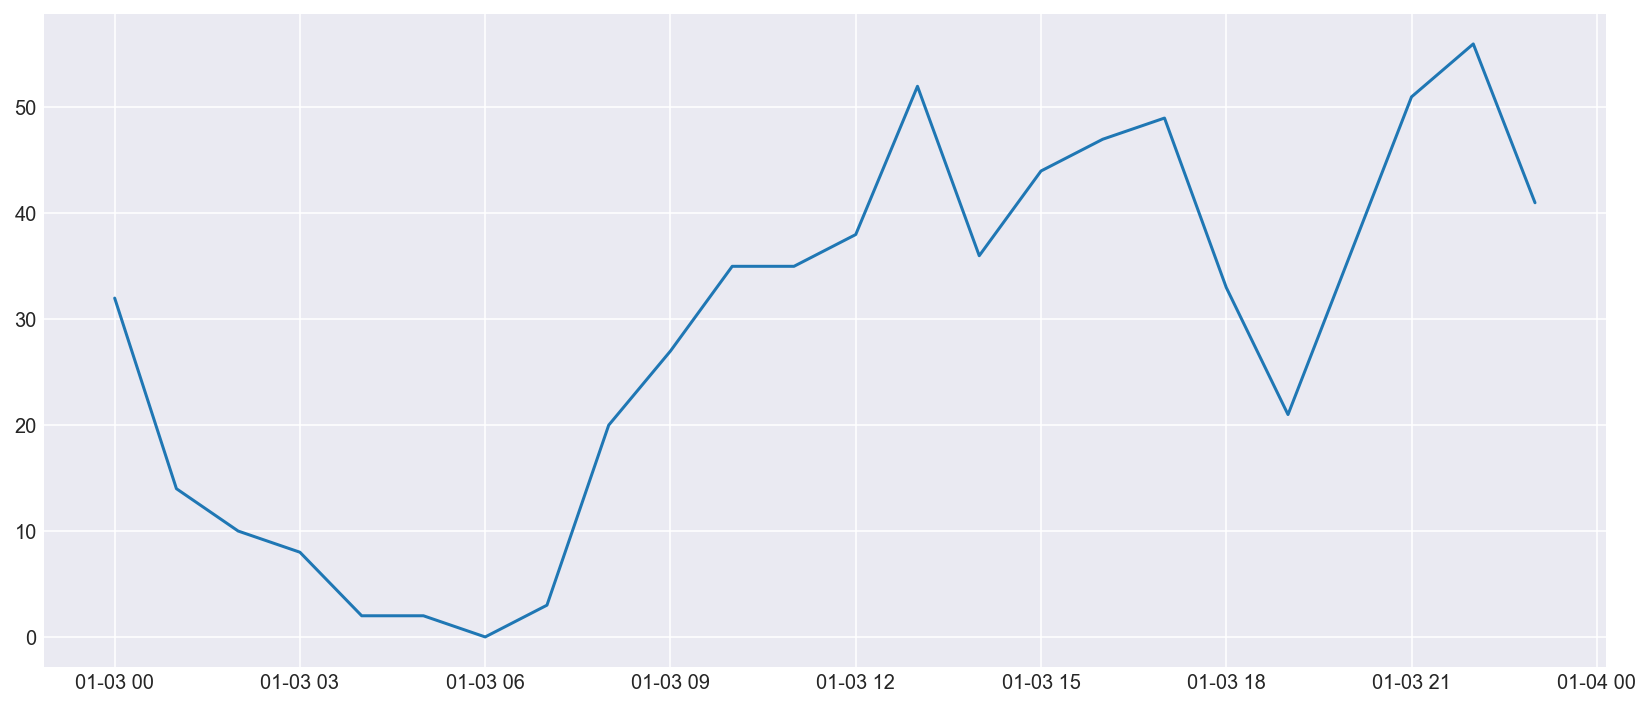

In [260]:
dat = qoo10_all[qoo10_all['Item code']==436358065][['Time','qty']]
dat['Time'] = pd.to_datetime(dat['Time'])
dat['qty'] = pd.to_numeric(dat['qty'])
dat = dat.sort_values('Time')
dat.index = dat['Time']
dat = dat.resample('H').sum().fillna('0')
plt.figure(figsize=(14,6))
plt.plot(dat)

In [261]:
qoo10_all = qoo10_all[qoo10_all['qty']<100]

## Global performance across time per hour

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


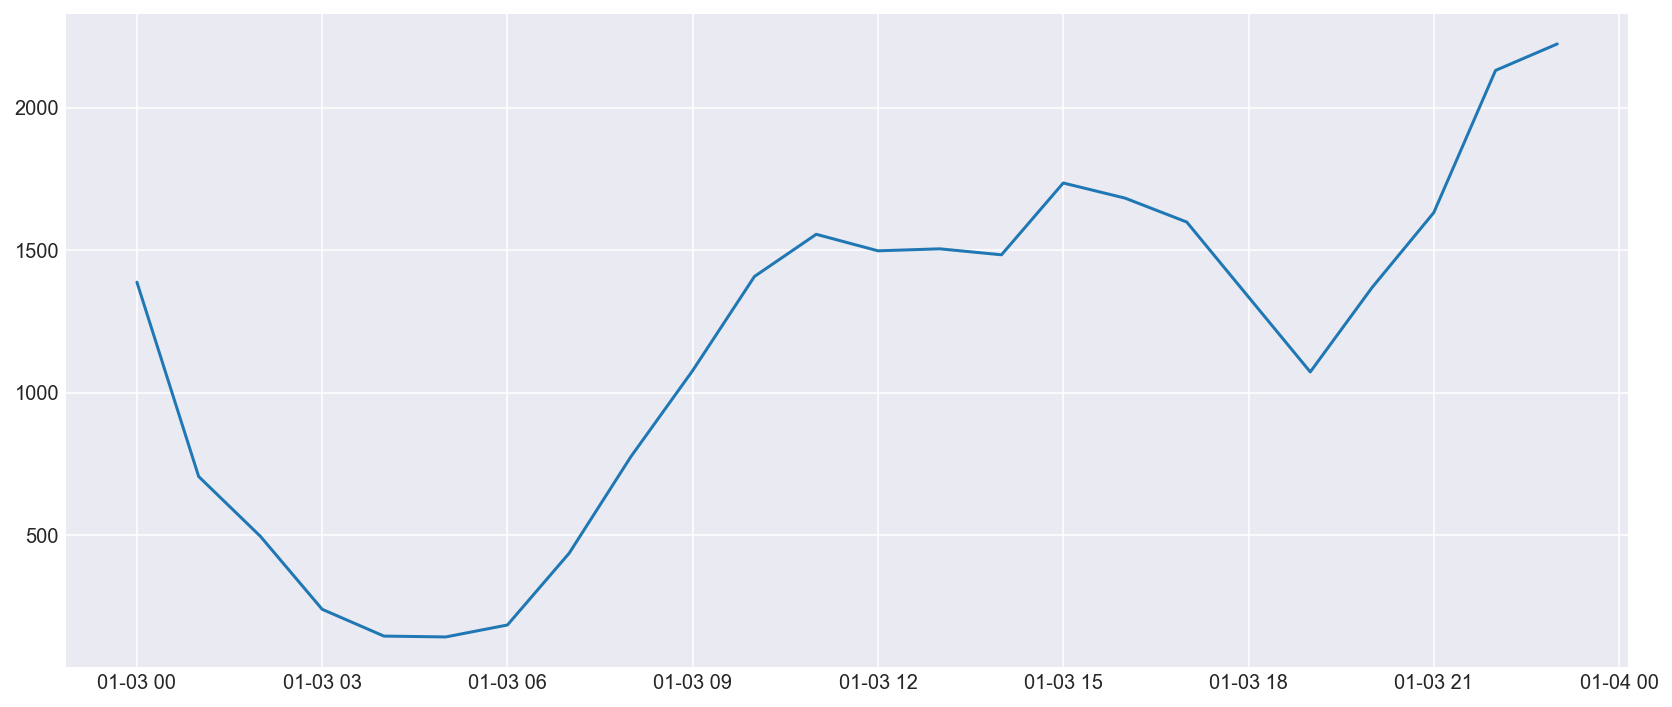

In [344]:
def time_analysis(df):
    df = df[['Time','qty']]
    df['Time'] = pd.to_datetime(df['Time'])
    df['qty'] = pd.to_numeric(df['qty'])
    df = df.sort_values('Time')
    df.index = df['Time']
    df = df.resample('H').sum().fillna('0')
    return df
    
dat = time_analysis(qoo10_all)
plt.figure(figsize=(14,6))
plt.plot(dat)


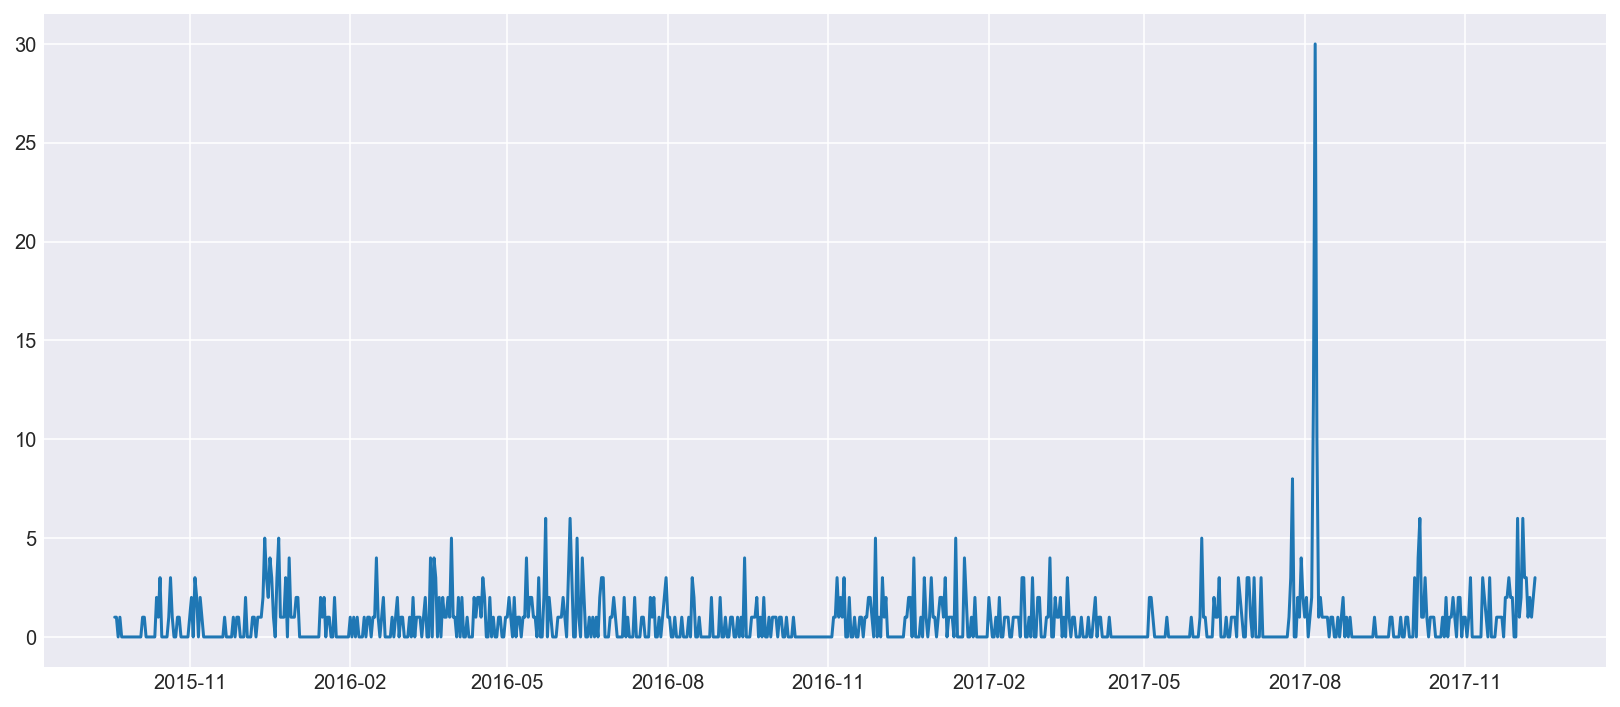

In [263]:
dat = qoo10_all[qoo10_all['Item code']==436358065][['Date','qty']]
dat['Date'] = pd.to_datetime(dat['Date'])
dat['qty'] = pd.to_numeric(dat['qty'])
dat = dat.sort_values('Date')
dat.index = dat['Date']
dat = dat.resample('d').sum().fillna('0')
plt.figure(figsize=(14,6))
plt.plot(dat)

In [264]:
Q_aug = qoo10_all[(qoo10_all['Item code']==436358065)&(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2017,8,1))&(pd.to_datetime(qoo10_all['Date']) < dt.datetime(2017,9,1))]

In [265]:
Q_aug.groupby('Date')[['qty']].sum().sort_values('qty',ascending=False).head()

qty
Date            
2017-08-07  30.0
2017-08-06  12.0
2017-08-08  10.0
2017-08-02   2.0
2017-08-05   2.0

In [266]:
Q_aug[Q_aug['Date']=='2017-08-07']

Order no.      Delivery company     Payment Complete  Item code  \
15960  224219497.0  Singpost normal mail  2017-08-07 08:45:43  436358065   
15962  224219832.0  Singpost normal mail  2017-08-07 08:56:04  436358065   
15964  224222000.0  Singpost normal mail  2017-08-07 09:22:23  436358065   
15965  224223293.0  Singpost normal mail  2017-08-07 09:54:22  436358065   
15966  224232295.0  Singpost normal mail  2017-08-07 12:22:24  436358065   
15967  224235371.0  Singpost normal mail  2017-08-07 12:58:41  436358065   
15968  224236178.0  Singpost normal mail  2017-08-07 13:18:16  436358065   
15969  224237482.0  Singpost normal mail  2017-08-07 13:40:16  436358065   
15971  224244353.0  Singpost normal mail  2017-08-07 15:12:02  436358065   
15972  224246623.0  Singpost normal mail  2017-08-07 15:42:10  436358065   
15974  224248403.0  Singpost normal mail  2017-08-07 16:21:16  436358065   
15976  224251654.0  Singpost normal mail  2017-08-07 17:40:37  436358065   
15977  224257123.0  Singpost normal mail  2017-08-07 20:17:35  436358065   
15979  224259254.0  Singpost normal mail  2017-08-07 21:10:58  436358065   
15980  224260419.0  Singpost normal mail  2017-08-07 21:31:46  436358065   
15981  224248123.0  Singpost normal mail  2017-08-07 21:45:59  436358065   
15986  224266683.0  Singpost normal mail  2017-08-07 23:07:14  436358065   
15990  224268031.0  Singpost normal mail  2017-08-07 23:25:26  436358065   
15993  224268218.0  Singpost normal mail  2017-08-07 23:28:08  436358065   
20770  224227377.0  Singpost normal mail  2017-08-07 10:57:29  436358065   
20771  224227378.0  Singpost normal mail  2017-08-07 10:57:29  436358065   
20779  224246823.0  Singpost normal mail  2017-08-07 15:46:47  436358065   
20780  224246824.0  Singpost normal mail  2017-08-07 15:46:47  436358065   
20781  224246825.0  Singpost normal mail  2017-08-07 15:46:47  436358065   
20786  224253082.0  Singpost normal mail  2017-08-07 18:18:28  436358065   
20787  224253081.0  Singpost normal mail  2017-08-07 18:18:28  436358065   
20788  224253080.0  Singpost normal mail  2017-08-07 18:18:28  436358065   
20795  224258382.0  Singpost normal mail  2017-08-07 20:50:41  436358065   

                                                    Item qty  \
15960  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15962  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15964  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15965  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15966  [BL Memory Foam Back Rest With Strap â˜… Breat...   2   
15967  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15968  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15969  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15971  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15972  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15974  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15976  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15977  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15979  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15980  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15981  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15986  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15990  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
15993  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20770  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20771  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20779  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20780  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20781  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20786  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20787  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20788  [BL Memory Foam Back Rest With Strap â˜… Breat...   1   
20795  [BL M

In [267]:
Q_aug[Q_aug['Date']=='2017-08-07']['Order no.'].value_counts()

224246824.0    1
224246623.0    1
224248403.0    1
224232295.0    1
224268218.0    1
224266683.0    1
224253080.0    1
224268031.0    1
224235371.0    1
224251654.0    1
224219497.0    1
224219832.0    1
224246825.0    1
224253082.0    1
224237482.0    1
224222000.0    1
224227377.0    1
224223293.0    1
224257123.0    1
224258382.0    1
224246823.0    1
224259254.0    1
224253081.0    1
224227378.0    1
224260419.0    1
224244353.0    1
224236178.0    1
224248123.0    1
Name: Order no., dtype: int64

In [268]:
q_rack = qoo10_all[qoo10_all['Item code'].apply(lambda x: x in [440532391, 427421167])]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


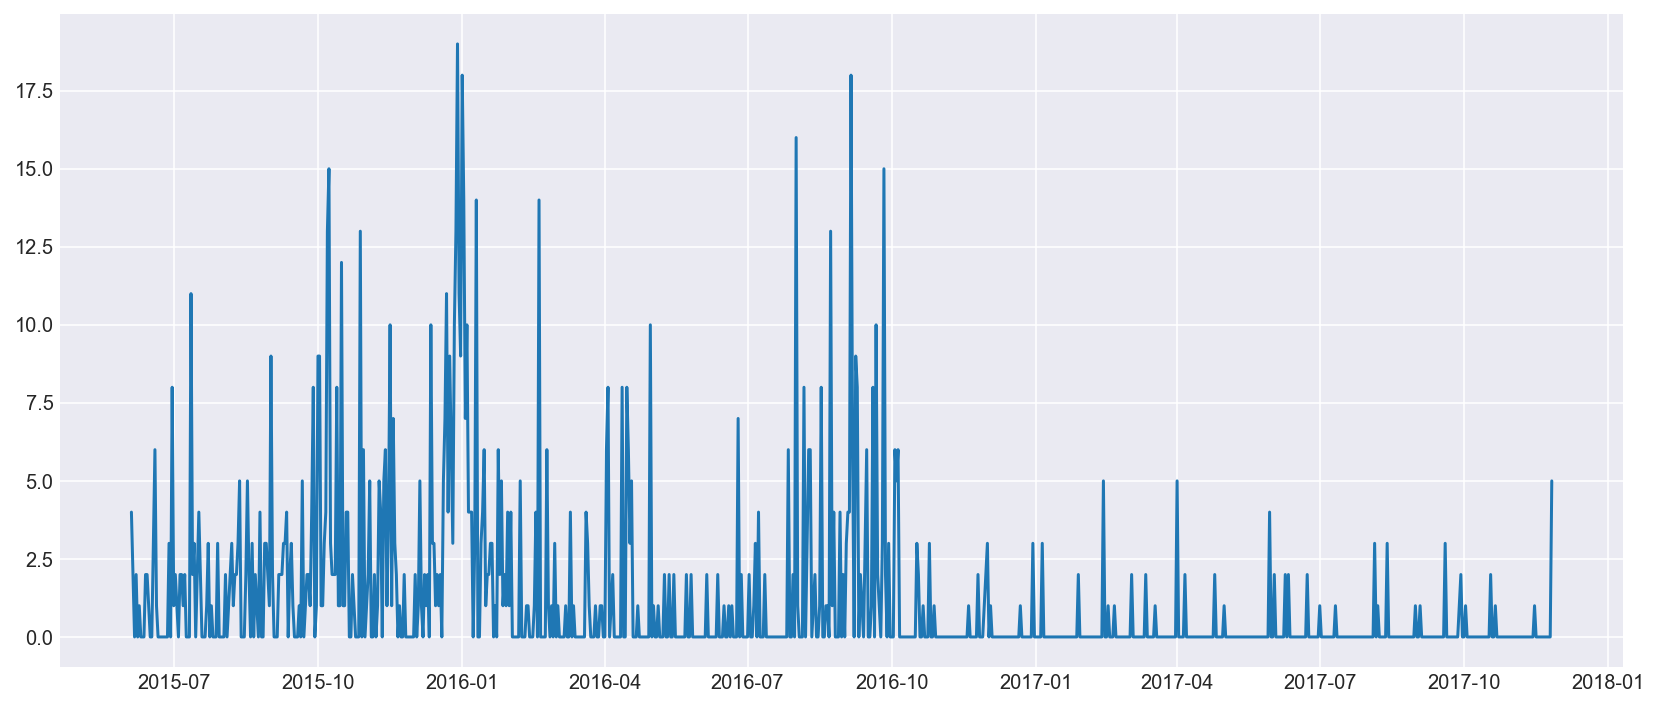

In [269]:
q_rack['Date'] = pd.to_datetime(q_rack['Date'])
q_rack['qty'] = pd.to_numeric(q_rack['qty'])
q_rack = q_rack.sort_values('Date')
q_rack.index = q_rack['Date']
q_rack = q_rack.resample('d').sum().fillna('0')
plt.figure(figsize=(14,6))
plt.plot(q_rack['qty'])

In [270]:
Q_backrest_all = qoo10_all[(qoo10_all['Item code']==436358065)&(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2017,7,1))]

In [271]:
Q_backrest_all.head()

Order no.      Delivery company     Payment Complete  Item code  \
15923  224119520.0  Singpost normal mail  2017-08-05 18:39:32  436358065   
15928  224126902.0  Singpost normal mail  2017-08-05 21:43:24  436358065   
15937  224170504.0  Singpost normal mail  2017-08-06 12:46:01  436358065   
15948  224170194.0  Singpost normal mail  2017-08-06 18:42:00  436358065   
15951  224191476.0  Singpost normal mail  2017-08-06 20:02:25  436358065   

                                                    Item qty  \
15923  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15928  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15937  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15948  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   
15951  [BL Memory Foam Back Rest With Strap ★ Breatha...   1   

                                                Options Sell Price  discount  \
15923  TYPE:BREATHABLE BACK REST / COLOR:SAPPHIRE BLUE        28.1      10.2   
15928          TYPE:MEMORY FOAM BACK REST / COLOR:BLUE        28.1      10.2   
15937    TYPE:MEMORY FOAM BACK REST / COLOR:LIGHT GREY        28.1      11.2   
15948          TYPE:MEMORY FOAM BACK REST / COLOR:BLUE        28.1      11.2   
15951          TYPE:MEMORY FOAM BACK REST / COLOR:BLUE        39.9      23.0   

             Date      Time                                               comb  
15923  2017-08-05  18:39:32  436358065 TYPE:BREATHABLE BACK REST / COLOR:SA...  
15928  2017-08-05  21:43:24  436358065 TYPE:MEMORY FOAM BACK REST / COLOR:B...  
15937  2017-08-06  12:46:01  436358065 TYPE:MEMORY FOAM BACK REST / COLOR:L...  
15948  2017-08-06  18:42:00  436358065 TYPE:MEMORY FOAM BACK REST / COLOR:B...  
15951  2017-08-06  20:02:25  436358065 TYPE:MEMORY FOAM BACK REST / COLOR:B...

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


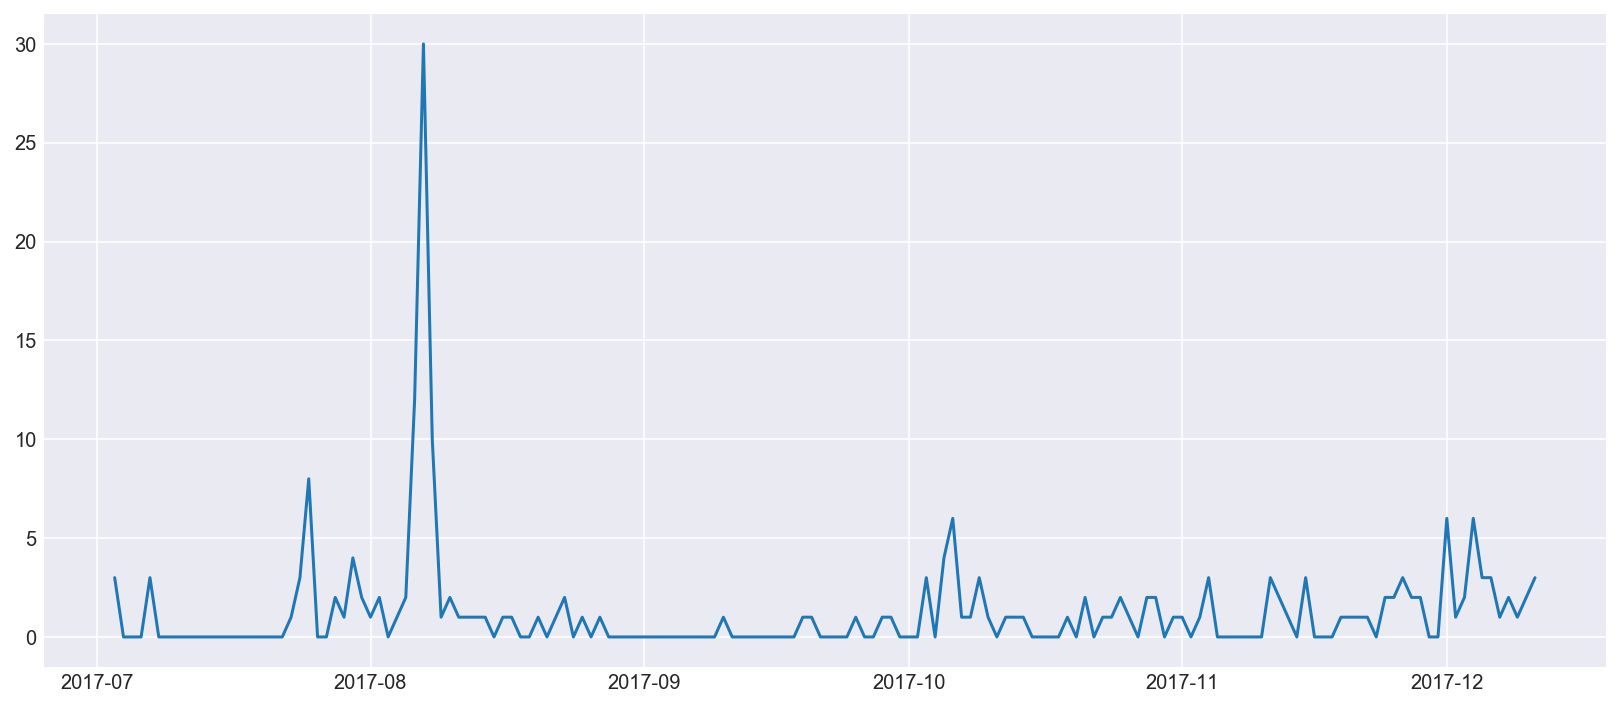

In [272]:
def date_analysis(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['qty'] = pd.to_numeric(df['qty'])
    df = df.sort_values('Date')
    df.index = df['Date']
    df = df.resample('d').sum().fillna('0')
    return df
q_backrest = date_analysis(Q_backrest_all)
plt.figure(figsize=(14,6))
plt.plot(q_backrest['qty'])

In [273]:
q_backrest.loc['2017-12-4':'2017-12-31',:]

Order no.    Item code qty discount
Date                                             
2017-12-04  7.16405e+08  1.30907e+09   6        0
2017-12-05  7.16747e+08  1.30907e+09   3        0
2017-12-06  7.16736e+08  1.30907e+09   3        5
2017-12-07  2.39008e+08  4.36358e+08   1        5
2017-12-08  4.78188e+08  8.72716e+08   2       10
2017-12-09  2.39208e+08  4.36358e+08   1        5
2017-12-10  4.78545e+08  8.72716e+08   2       10
2017-12-11  7.18211e+08  1.30907e+09   3    12.49

In [274]:
#writer = pd.ExcelWriter('Qoo10_backrest.xlsx', engine='xlsxwriter')
#Q_backrest_all.to_excel(writer, sheet_name='Sheet1')
#writer.save()

## Short part of the code to visualise Timeseries sales

In [275]:
q_thing = qoo10_all[(qoo10_all['Item code']==539847724)&(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2017,6,30))&(pd.to_datetime(qoo10_all['Date']) < dt.datetime(2017,7,8))]

In [276]:
q_thing.head()

Empty DataFrame
Columns: [Order no., Delivery company, Payment Complete, Item code, Item, qty, Options, Sell Price, discount, Date, Time, comb]
Index: []

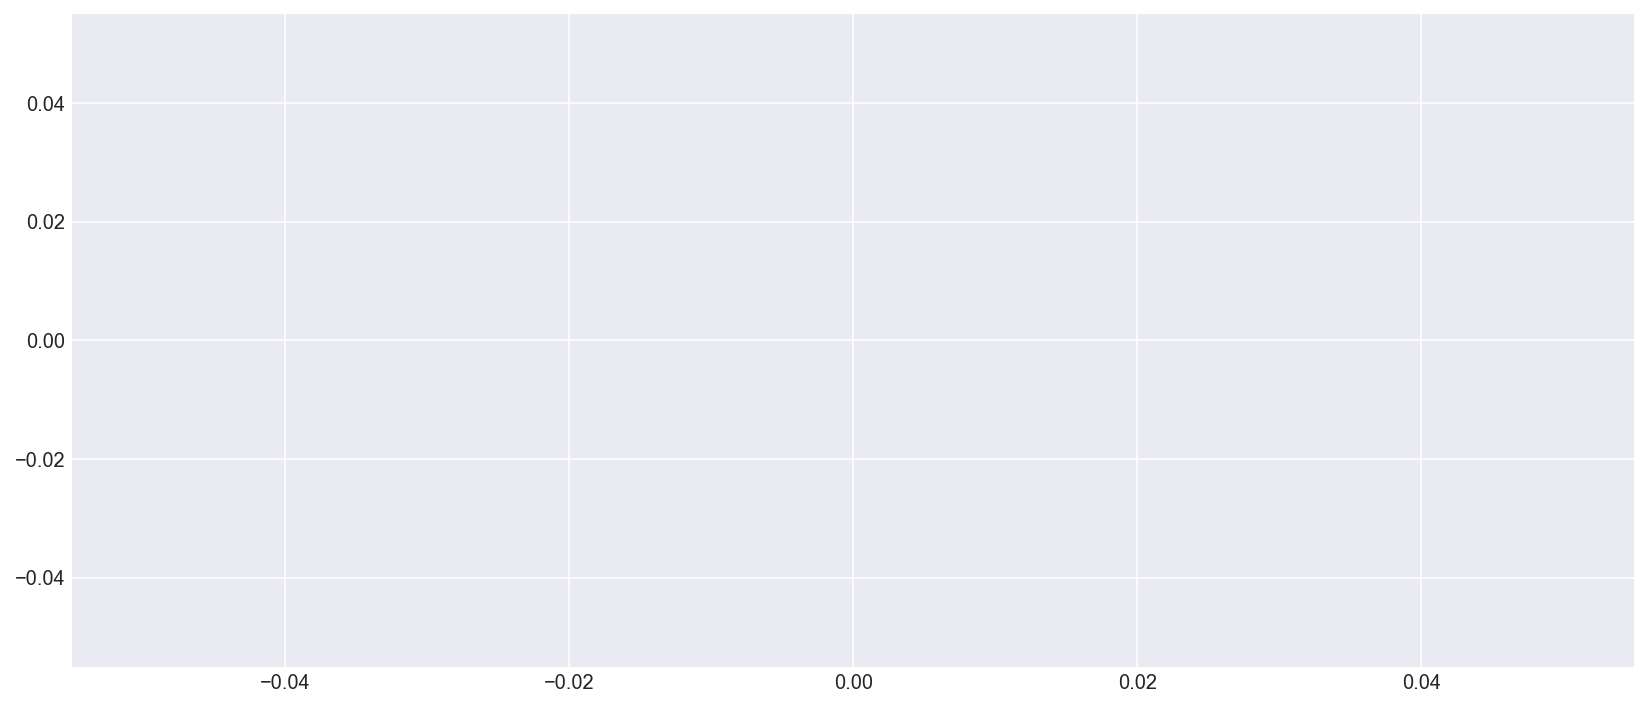

In [277]:
q_thing = date_analysis(q_thing)
plt.figure(figsize=(14,6))
plt.plot(q_thing['qty'], marker='x')

## Continue

In [278]:
qoo10_all.head()

Order no.      Delivery company       Payment Complete  Item code  \
0  46912738.0  Singpost normal mail  Sep 22, 2014 21:32:09  419731390   
1  46916402.0  Singpost normal mail  Sep 22, 2014 21:54:32  419731390   
2  46921095.0  Singpost normal mail  Sep 22, 2014 23:31:41  419731390   
3  46987317.0  Singpost normal mail  Sep 24, 2014 22:57:16  419731390   
4  47001604.0  Singpost normal mail  Sep 25, 2014 12:45:03  419731390   

                                                Item qty  \
0  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
1  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
2  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
3  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   
4  ã€GroupBuy Saleã€‘â˜…Free Shippingâ˜… iPhone ...   1   

                                             Options Sell Price  discount  \
0  Model:2: Candy Solid Back(+S$1) / Screen Prote...          9       0.0   
1  Model:8: Graphic Series(+S$1.90) / Screen Prot...          9       0.0   
2  Model:7: Vintage Series(+S$3.90) / Screen Prot...          9       0.0   
3  Model:5: Royalty Series(+S$2.90) / Screen Prot...          9       0.0   
4  Model:7: Vintage Series(+S$3.90) / Screen Prot...          9       0.0   

         Date      Time                                               comb  
0  2014-09-22  21:32:09  419731390 Model:2: Candy Solid Back(+S$1) / Sc...  
1  2014-09-22  21:54:32  419731390 Model:8: Graphic Series(+S$1.90) / S...  
2  2014-09-22  23:31:41  419731390 Model:7: Vintage Series(+S$3.90) / S...  
3  2014-09-24  22:57:16  419731390 Model:5: Royalty Series(+S$2.90) / S...  
4  2014-09-25  12:45:03  419731390 Model:7: Vintage Series(+S$3.90) / S...

In [279]:
#Get day of the week
qoo10_all['Day'] = qoo10_all['Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))

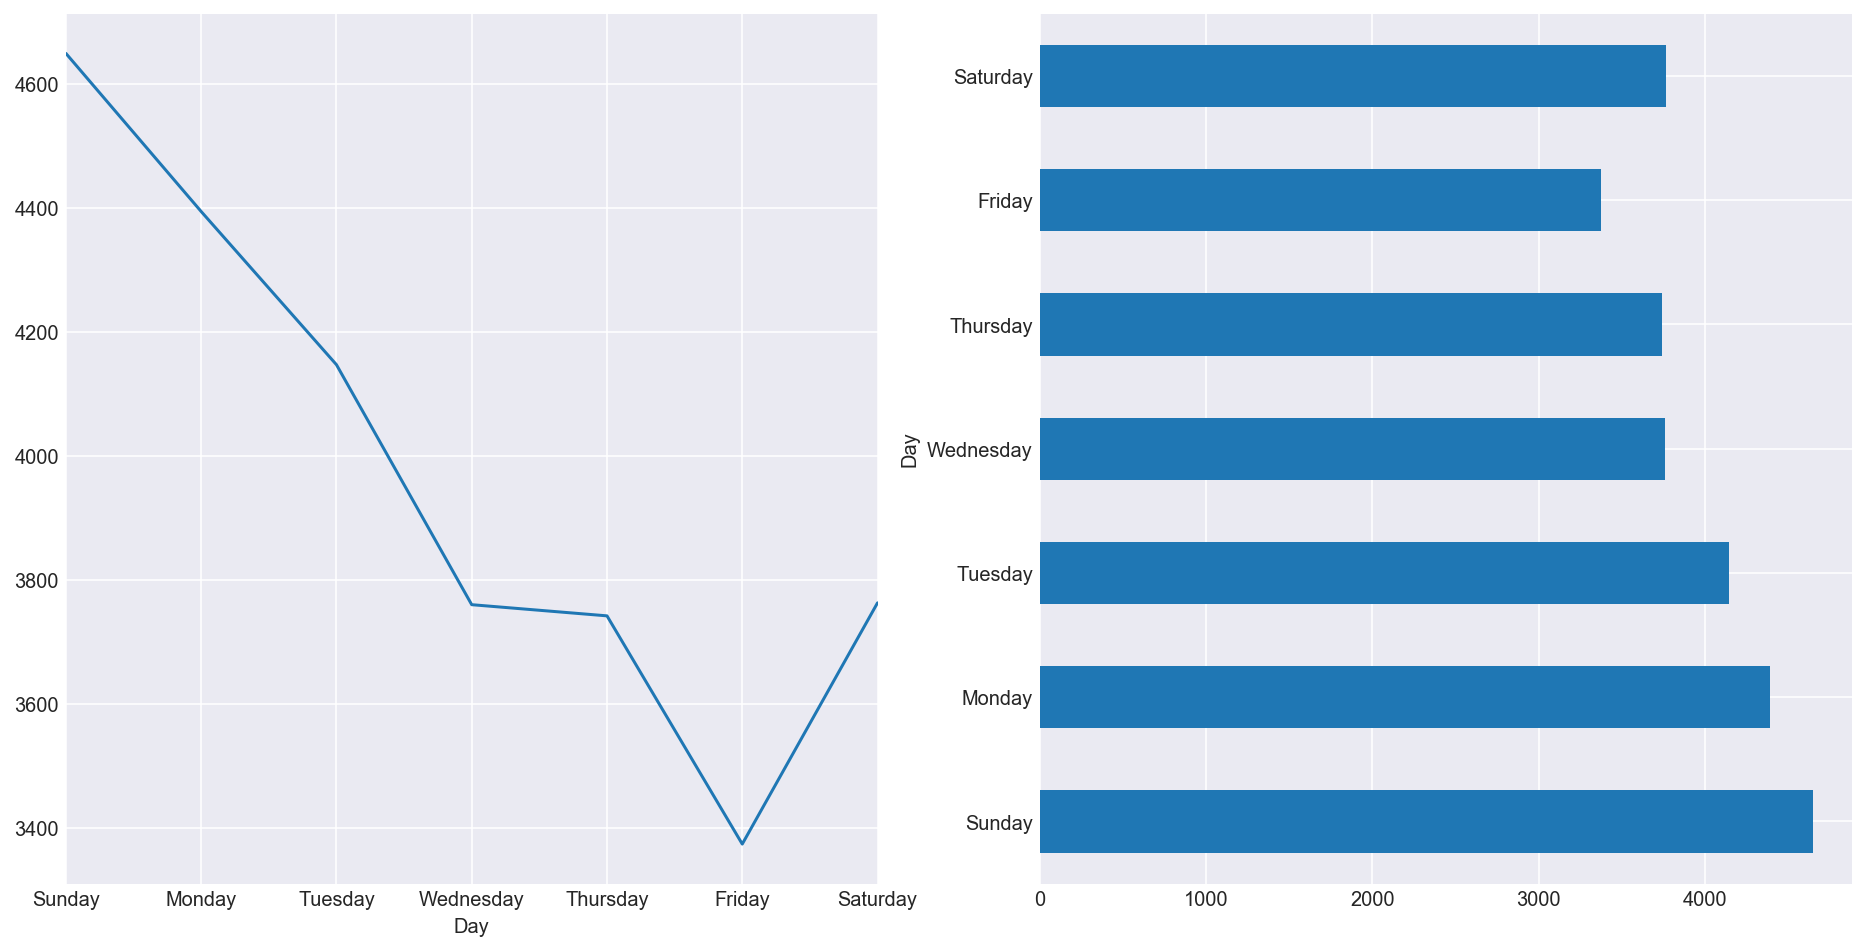

In [280]:
plt.figure(figsize=(16,8))

qoo10_day_analysis = qoo10_all.groupby('Day')['qty'].sum()
qoo10_day_analysis = qoo10_day_analysis.reindex(index=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.subplot(121)
qoo10_day_analysis.plot()
plt.subplot(122)
qoo10_day_analysis.plot.barh()


In [281]:
qoo10_all['n_day'] = qoo10_all['Date'].apply(lambda x:x[-2:])

Text(0.5,1,u'Jan 2017 qty by day')

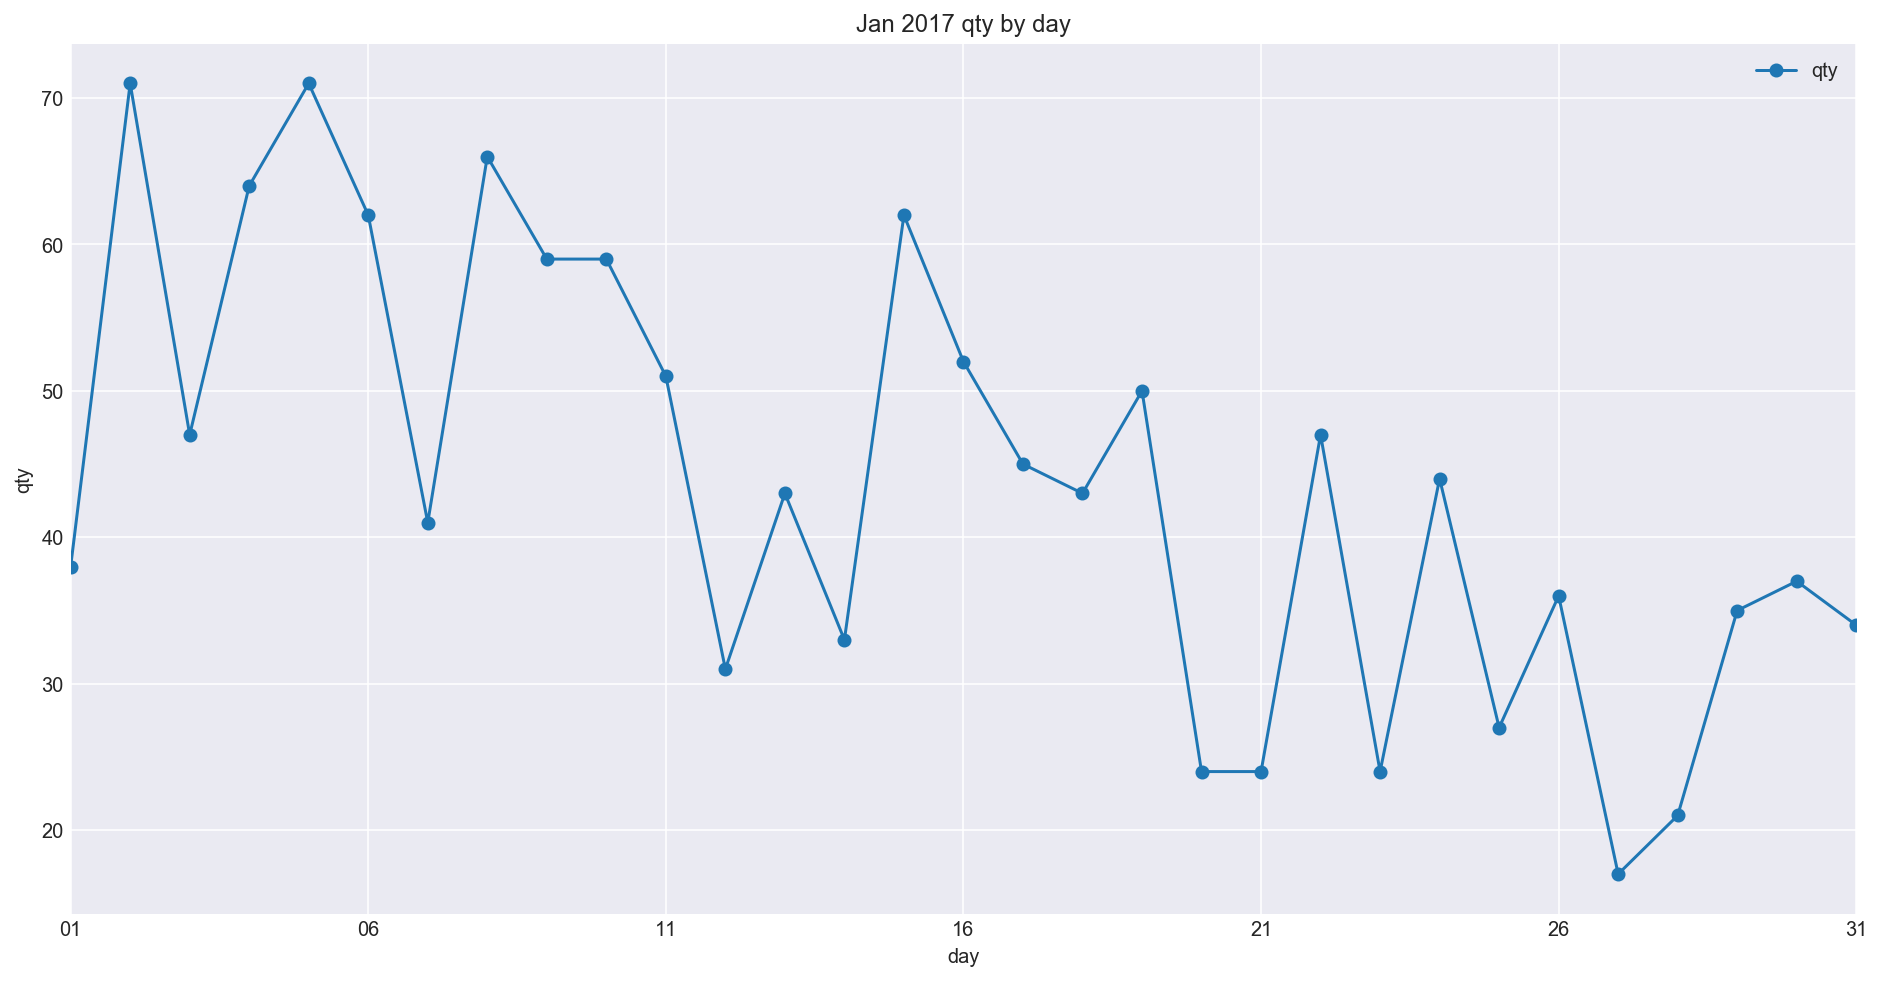

In [307]:
q_range17 = qoo10_all[(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2016,12,31))&(pd.to_datetime(qoo10_all['Date']) < dt.datetime(2017,2,1))][['qty','n_day']]
q_range17.groupby('n_day').sum().plot(marker='o', figsize=(16,8))
plt.ylabel('qty')
plt.xlabel('day')
plt.title('Jan 2017 qty by day')

Text(0.5,1,u'Jan 2016 qty by day')

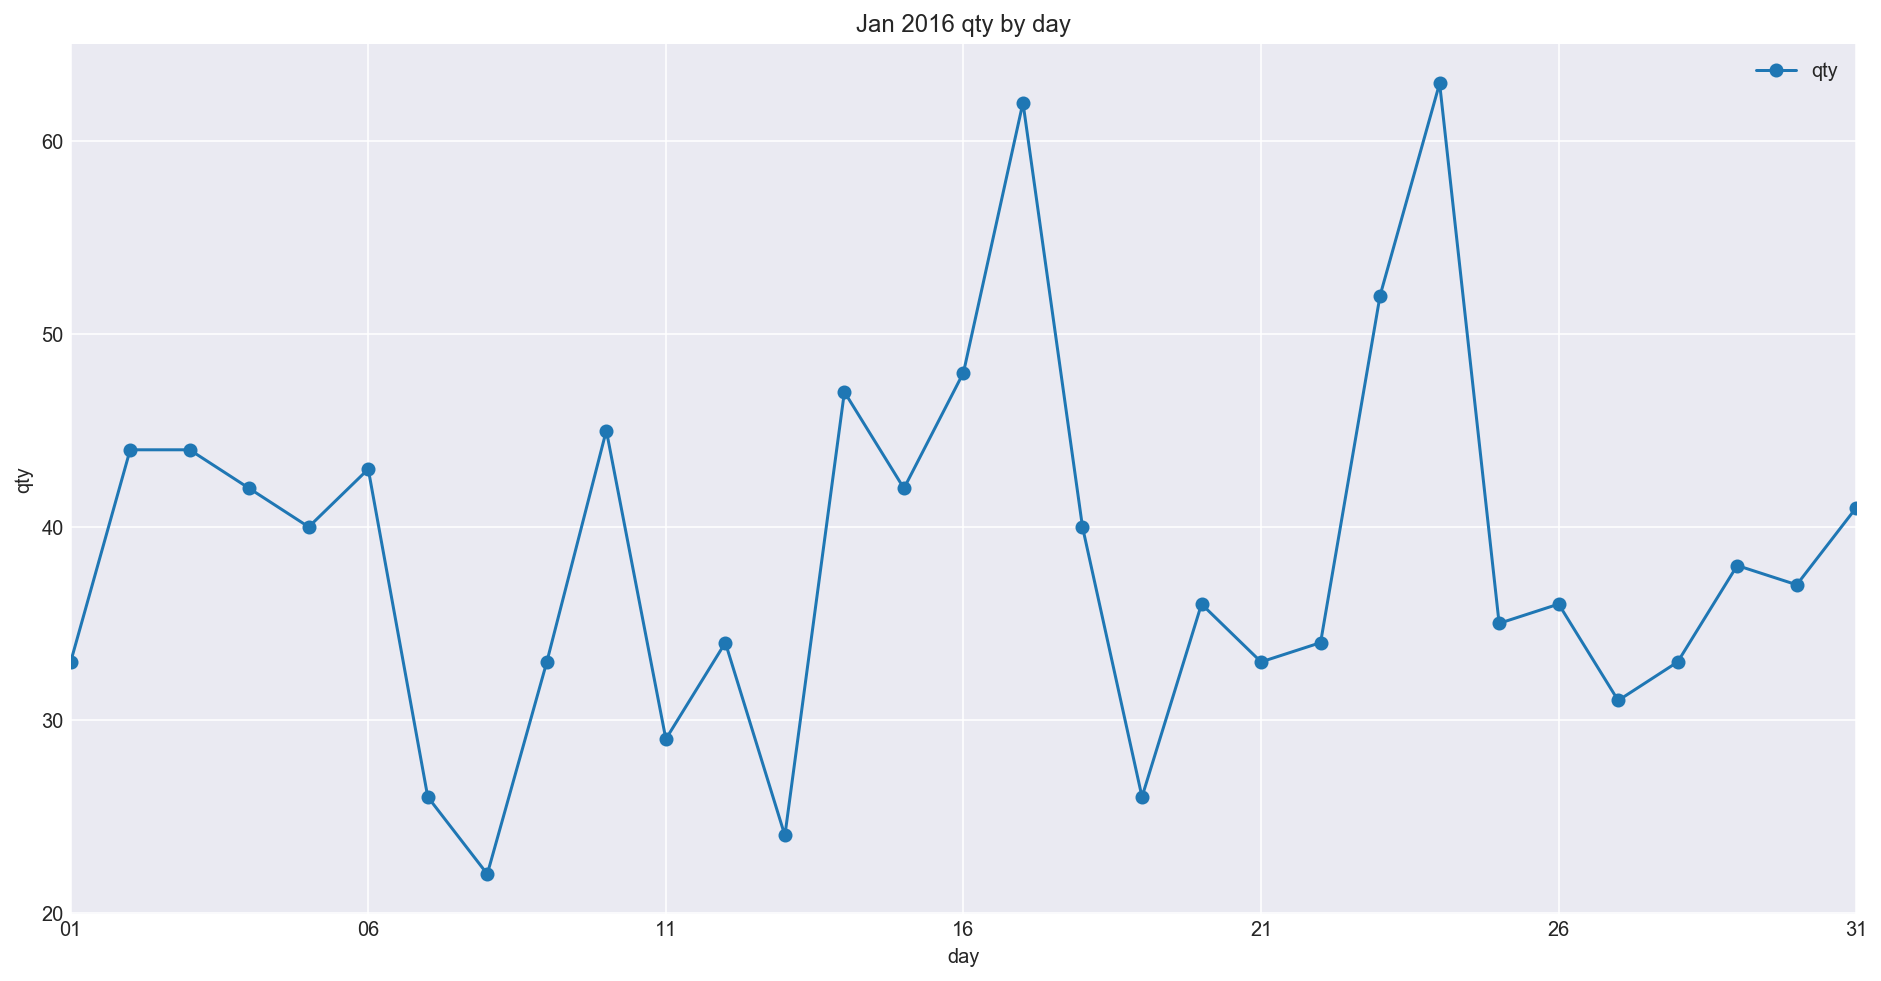

In [308]:
q_range16 = qoo10_all[(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2015,12,31))&(pd.to_datetime(qoo10_all['Date']) < dt.datetime(2016,2,1))][['qty','n_day']]
q_range16.groupby('n_day').sum().plot(marker='o', figsize=(16,8))
plt.ylabel('qty')
plt.xlabel('day')
plt.title('Jan 2016 qty by day')

In [288]:
q_range.sum()

qty      927.000000
n_day           inf
dtype: float64

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


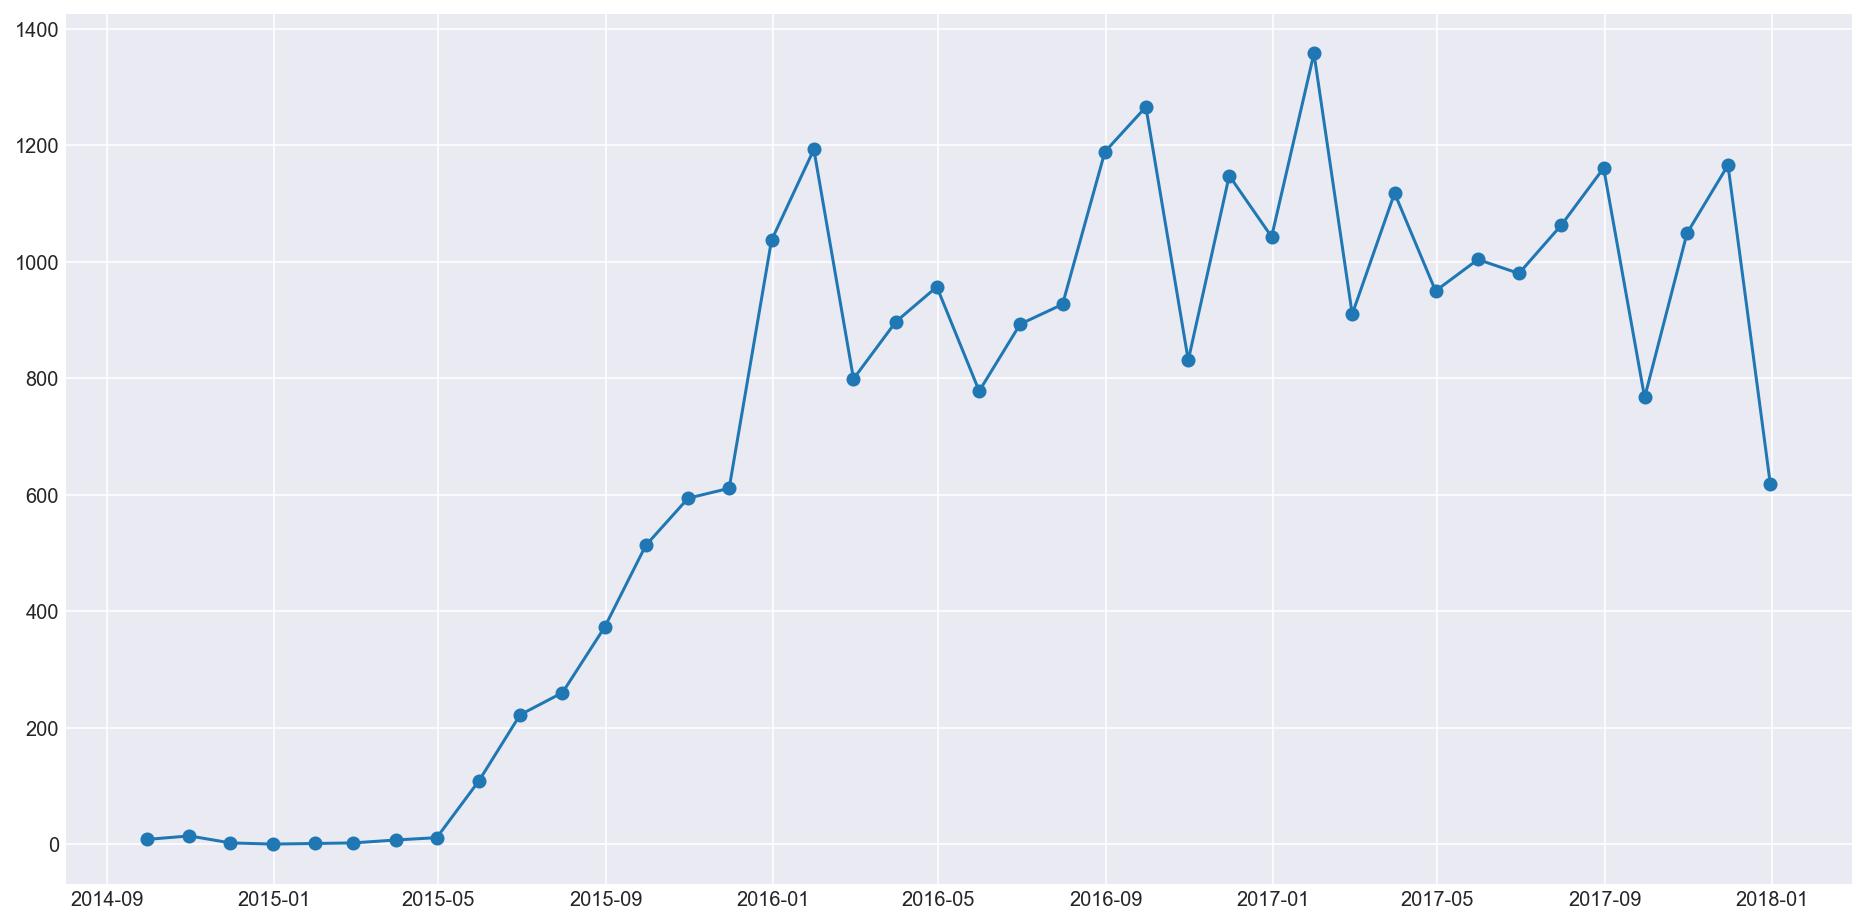

In [294]:
glob = qoo10_all[['Date','qty']]
glob['Date'] = pd.to_datetime(glob['Date'])
glob.index = glob['Date']
glob = glob.resample('M').sum()
plt.figure(figsize=(16,8))
plt.plot(glob['qty'], marker='o')

In [300]:
glob[glob.index > dt.datetime(2017,1,1)]

qty
Date              
2017-01-31  1358.0
2017-02-28   910.0
2017-03-31  1118.0
2017-04-30   950.0
2017-05-31  1004.0
2017-06-30   980.0
2017-07-31  1063.0
2017-08-31  1161.0
2017-09-30   767.0
2017-10-31  1049.0
2017-11-30  1166.0
2017-12-31   618.0

In [ ]:
q_range17_all = qoo10_all[(pd.to_datetime(qoo10_all['Date']) > dt.datetime(2016,12,31))&(pd.to_datetime(qoo10_all['Date']) < dt.datetime(2017,2,1))]

In [ ]:
q_range17_all['Sell Price'] = q_range17_all['Sell Price'].astype(int).fillna(0)
cat1 = q_range17_all.groupby('Item code')[['Item','qty']].sum()
cat2 = q_range17_all.groupby('Item code')[['Sell Price']].median()
cat3 = pd.concat([cat1, cat2], axis=1)
cat3['Total Sale'] = cat3['qty']*cat3['Sell Price']
cat3.sort_values('Total Sale', ascending=False).head(30)

### Split the dataset by selling price

In [343]:
qoo10m30 = qoo10_all[qoo10_all['Sell Price'] >= 30]
qoo10l30 = qoo10_all[qoo10_all['Sell Price'] < 30]
qoo10m30.shape
qoo10l30.shape

(21308, 14)

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5,1,u'Global performance for items >$30')

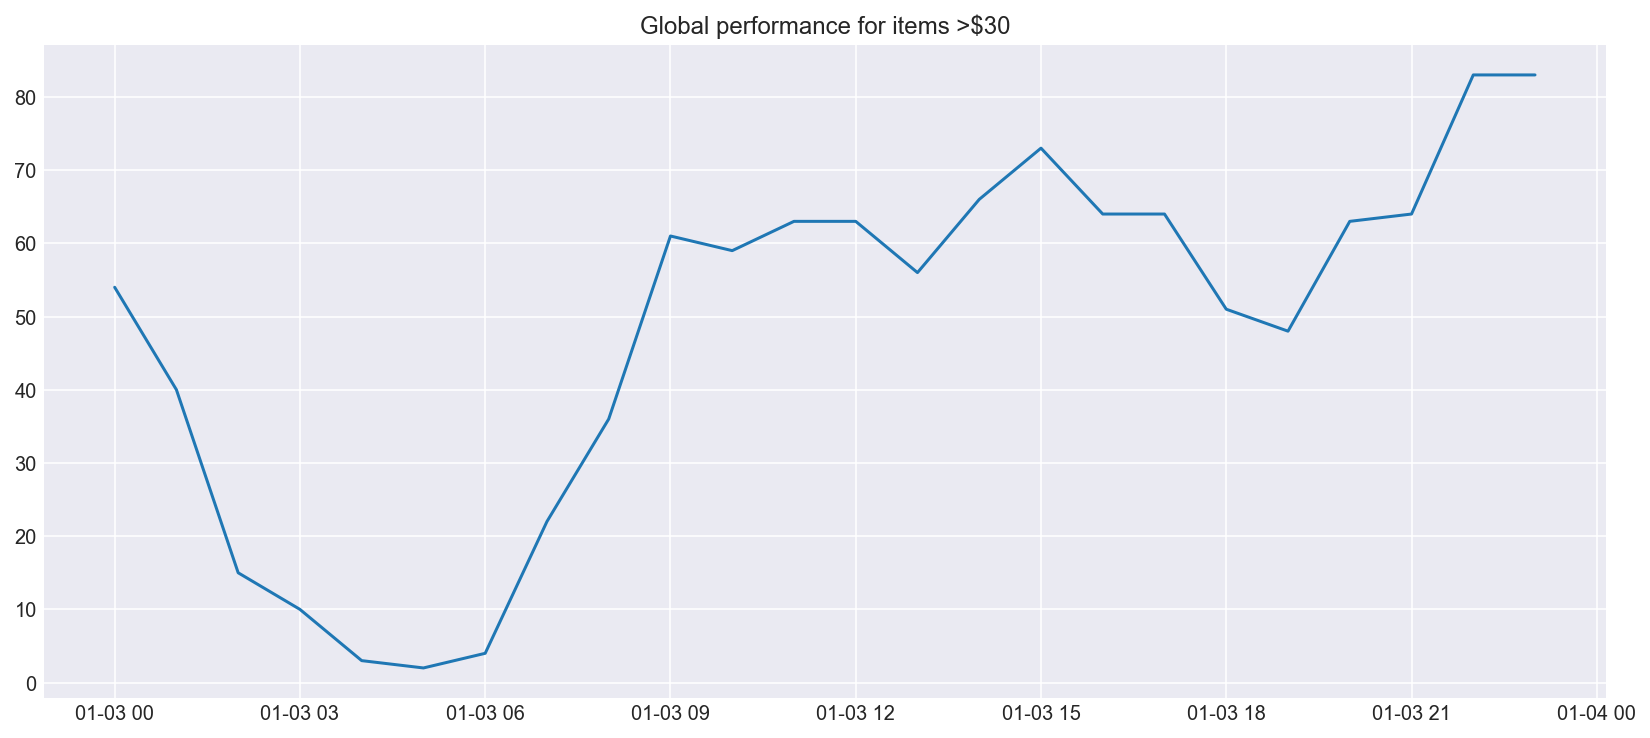

In [363]:
dat1 = time_analysis(qoo10m30)
plt.figure(figsize=(14,6))
plt.plot(dat1)
plt.title('Global performance for items >$30')

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5,1,u'Global performance for items <$30')

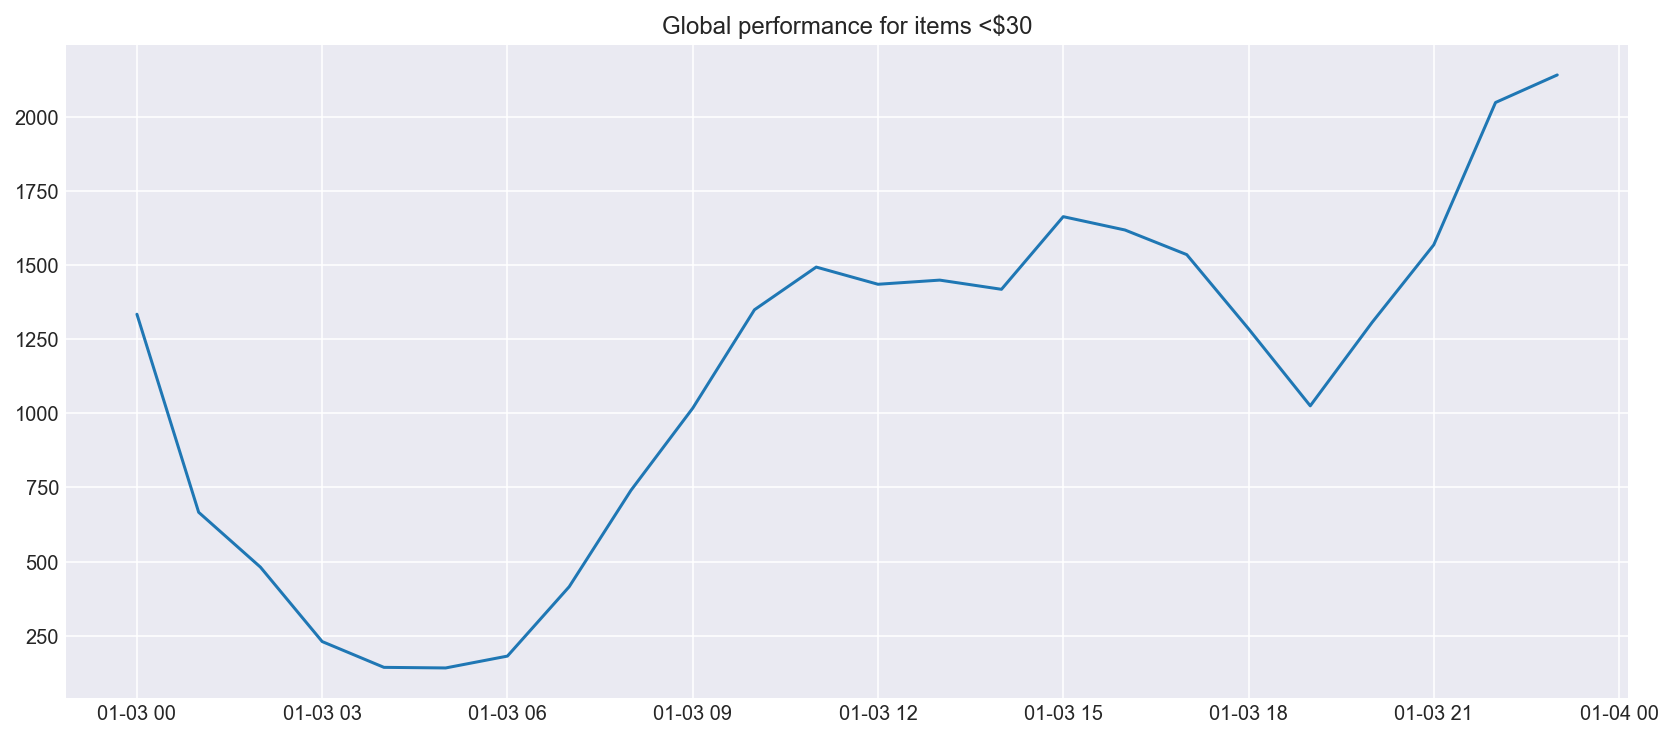

In [364]:
dat2 = time_analysis(qoo10l30)
plt.figure(figsize=(14,6))
plt.plot(dat2)
plt.title('Global performance for items <$30')

In [360]:
#While performing value_counts on Sell Price, there is a SGD value in it. Drop that
#qoo10m30 = qoo10m30.drop(20318, axis=0)
qoo10m30['Sell Price'] = qoo10m30['Sell Price'].astype(float)
qoo10m30['Sell Price'].dtype

dtype('float64')

In [365]:
def sale(df):
    df['Sell Price'] = df['Sell Price'].astype(float).fillna(0)
    cat1 = df.groupby('Item code')[['Item','qty']].sum()
    cat2 = df.groupby('Item code')[['Sell Price']].median()
    cat3 = pd.concat([cat1, cat2], axis=1)
    cat3['Total Sale'] = cat3['qty']*cat3['Sell Price']
    return cat3

In [366]:
#qoo10m30['Sell Price'] = qoo10m30['Sell Price'].astype(float).fillna(0)
#cat1 = qoo10m30.groupby('Item code')[['Item','qty']].sum()
#cat2 = qoo10m30.groupby('Item code')[['Sell Price']].median()
#cat3 = pd.concat([cat1, cat2], axis=1)
#cat3['Total Sale'] = cat3['qty']*cat3['Sell Price']
more_30 = sale(qoo10m30)
more_30.sort_values('Total Sale', ascending=False).head(30)

Item    qty  \
Item code                                                             
438617985  â˜…â˜…Christmas Tree + Decor â˜…â˜… THEMED 1.5...  123.0   
439308546  â˜… Moving Laundry Organizer Rack â˜… 2 or 3 T...  206.0   
507858491  â˜… Large Capacity Moving Laundry Basket â˜… V...   89.0   
476224249  â˜… Stainless Steel Dish Rack â˜… Crockery Cut...   65.0   
484625271  ★ Improvised Shoe Rack Stool ★ 4 Different Len...   88.0   
507874902  â˜… Pets Bed â˜… Your Pet Dog And Cat Own Comf...   39.0   
498086184  ★ Ultra-Slim Minimalist Shoe Cabinet ★ 3 Tier ...   24.0   
436358065  [BL Memory Foam Back Rest With Strap ★ Breatha...   44.0   
491467047  â˜… Stainless Steel Pedal Bin â˜… Silent Flip ...   52.0   
486777155  ★ Rollable Table ★ Convenient Bedside Sofa Tra...   46.0   
483343692  ★ Wooden Display Stand ★ 5 Level Design! DIY D...   25.0   
481711170  â˜… Ivory Vanity Organizer â˜… Wooden Drawers ...   33.0   
490764100  â˜… 40-Inch Bounce Fit Foldable Trampoline â˜…...   12.0   
434945690  â˜… Hopu HP-118 Binding Machine â˜… Binds Book...    8.0   
483353027  â˜… Wooden Compartmentalized Shelf â˜… 5 or 7 ...   26.0   
490489871  ★ Space Saving Upper Storage Rack ★ Bathroom T...   27.0   
425741016  â˜… Educational World Map Jigsaw for Kids â˜… ...   22.0   
507889358  â˜… Guitar Stands â˜… With Sponge Padding Keep...   21.0   
490650815  ★ Stainless Steel Rack on Rollers ★ Space Savi...   17.0   
492506488  ★ Wooden Compartmentalized Shelf ★ 5 or 7 Comp...   18.0   
484286693  ★ Baby Treetop Friends Activity Gym ★ Infant E...   11.0   
453266027  â˜… 13-Compartment Tabletop Document Organizer...   15.0   
513997827  â˜… XL Business Backpack â˜… Laptop Compartmen...   11.0   
504508988  ★ Cooling Mat for Bed and Car Seat ★ Auto Cool...   12.0   
434930865  â˜… Robotic Vacuum Cleaner â˜… Comes With 2 Si...    4.0   
507256906  â˜… Large Rectangular Floor Rug (120 x 160cm) ...   12.0   
509035977  â˜… Triple Tier Stainless Steel Dish Rack â˜… ...    7.0   
490642127  ★ Pikachu Anime Plush Blanket ★ Pokemon Go Tra...    8.0   
547548879  â˜… Improvised Shoe Rack Stool â˜… 4 Different...    9.0   
440535321  â˜… Unique Lovely Sofa Covers â˜… Many Beautif...    7.0   

           Sell Price  Total Sale  
Item code                          
438617985        69.0      8487.0  
439308546        30.0      6180.0  
507858491        35.0      3115.0  
476224249        44.0      2860.0  
484625271        30.0      2640.0  
507874902        58.0      2262.0  
498086184        90.0      2160.0  
436358065        39.0      1716.0  
491467047        32.0      1664.0  
486777155        30.0      1380.0  
483343692        55.0      1375.0  
481711170        35.0      1155.0  
490764100        89.0      1068.0  
434945690       129.0      1032.0  
483353027        33.0       858.0  
490489871        30.0       810.0  
425741016        30.0       660.0  
507889358        30.0       630.0  
490650815        35.0       595.0  
492506488        33.0       594.0  
484286693        43.0       473.0  
453266027        30.0       450.0  
513997827        35.0       385.0  
504508988        32.0       384.0  
434930865        91.0       364.0  
507256906        30.0       360.0  
509035977        49.0       343.0  
490642127        40.0       320.0  
547548879        30.0       270.0  
440535321        35.0       245.0

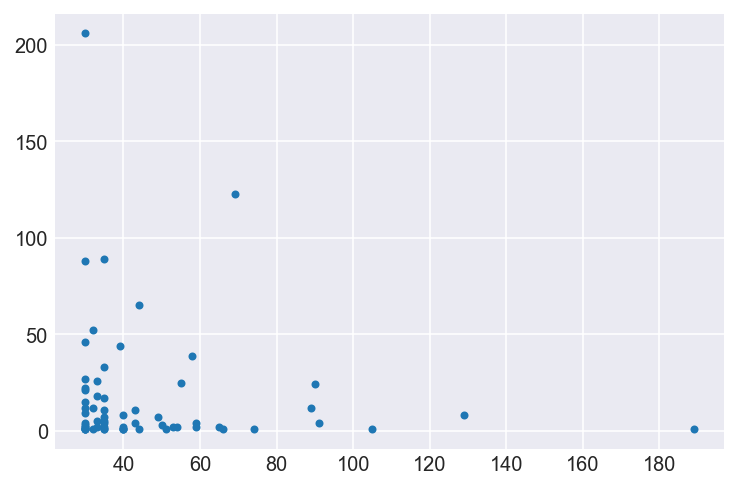

In [369]:
plt.plot(more_30['Sell Price'], more_30['qty'], marker='.', ls='None')

In [367]:
less_30 = sale(qoo10l30)
less_30.sort_values('Total Sale', ascending=False).head(30)

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Item     qty  \
Item code                                                              
426404126  â˜… Transparent Smart Storage Box â˜… Stackabl...  1601.0   
436358065  [Effective] â˜… Memory Foam Back Rest With Str...   648.0   
427421167  â˜… Extendable Rack â˜… White Bars or Stainles...   886.0   
436716506  [Multi-color] â˜… Anti-Slip Cooling Mat! â˜… M...  1112.0   
425937308  â˜… Modern Classic Bathroom Racks â˜… 5 Types!...   516.0   
435026212  â˜… Hat and Coat Stand â˜… Hang Clothes Jacket...   406.0   
427748529  â¤ Jewellery Organizer with Hooks â¤ Black /...   425.0   
427759221  â¤ Wardrobe Organizers â¤ White / Blue / Pin...   412.0   
427251228  â˜… Wooden Stationery Organizer â˜… Large Clas...   263.0   
436152021  â˜… Foldable Dual Pouch Laundry Basket â˜… Col...   266.0   
433763226   â˜… See-Through Classy Stationery Organizer â...   335.0   
432362777  â˜… Smart Utensils and Dish Rack â˜… 3 Types! ...   247.0   
435096378  â˜… Smart Utensils and Dish Rack â˜… 3 Types! ...   237.0   
427747421  â¤ Bag Organizer â¤ White / Blue / Pink - Ba...   243.0   
426493322  â˜… USB Extension Plug â˜… USB3.0 Fast Transfe...   212.0   
420841071  World Map Poster - Around the Globe - Local Se...   226.0   
440465412  â˜… Convenient Open Air Clothing Rack â˜… Full...   169.0   
435827132  â˜… Trolley Cart â˜… With Free Detachable Insu...   185.0   
440299380  â˜… Bathroom Floor Mat â˜… Waterproof Anti-Sli...   242.0   
439763958  â˜… Memory Foam Pain Relief Neck Rest â˜… [Enh...   138.0   
436781693  ★ Breathable Back Rest Cushion with Strap ★ Ba...   131.0   
432351343  â˜… Bulletin Board â˜… Comes With Pins For Pin...   152.0   
458660095  â˜… Handheld Garment Steamer â˜… Keep Clothes ...   105.0   
436367781  â˜… Assorted CD Case / Pouch â˜… 3 Types! Orga...   288.0   
472129544  â˜… Shoe Cabinet Rack â˜… Multi-Tier Convenien...   132.0   
484265012  â˜… Easy Storage Jar â˜… Stackable Transparent...   365.0   
441069153  â˜… Clip-on Car Dustbin â˜… Mini Trash Rubbish...   312.0   
490648942  ★ Stainless Steel Microwave Space-Saving Rack ...   115.0   
440532391  â˜… Extendable Rack â˜… White Bars or Stainles...   206.0   
440803603  â˜… Tabletop Remote Control Holder â˜… 4 Compa...   277.0   

           Sell Price  Total Sale  
Item code                          
426404126        13.0     20813.0  
436358065        22.0     14256.0  
427421167        16.0     14176.0  
436716506        10.0     11120.0  
425937308        15.0      7740.0  
435026212        18.0      7308.0  
427748529        17.0      7225.0  
427759221        16.0      6592.0  
427251228        20.0      5260.0  
436152021        19.0      5054.0  
433763226        15.0      5025.0  
432362777        20.0      4940.0  
435096378        17.0      4029.0  
427747421        16.0      3888.0  
426493322        16.0      3392.0  
420841071        15.0      3390.0  
440465412        20.0      3380.0  
435827132        18.0      3330.0  
440299380        13.0      3146.0  
439763958        20.0      2760.0  
436781693        21.0      2751.0  
432351343        18.0      2736.0  
458660095        26.0      2730.0  
436367781         8.0      2304.0  
472129544        17.0      2244.0  
484265012         6.0      2190.0  
441069153         7.0      2184.0  
490648942        18.0      2070.0  
440532391        10.0      2060.0  
440803603         7.0      1939.0

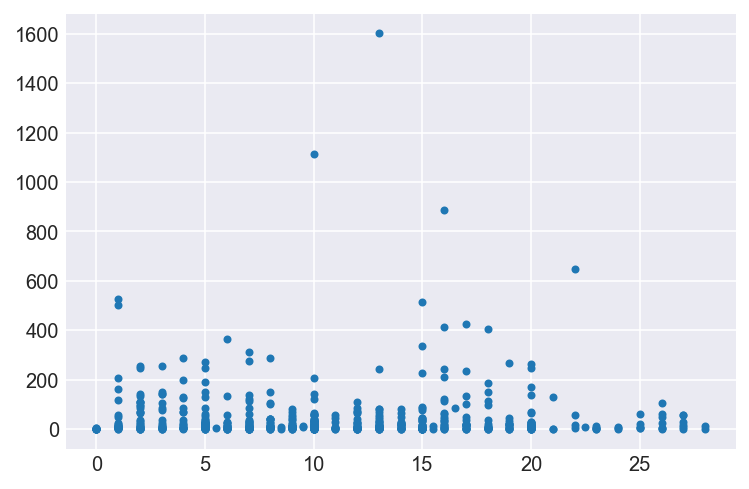

In [371]:
plt.plot(less_30['Sell Price'], less_30['qty'], marker='.', ls='None')

In [372]:
writer = pd.ExcelWriter('Qoo10_30perf.xlsx', engine='xlsxwriter')
less_30.to_excel(writer, sheet_name='less30')
more_30.to_excel(writer, sheet_name='more30')
writer.save()

## 2nd project: Hidden gems

Synopsis: I want to know where I can go when I visit a certain place. Specifically I would like to go to places recommended by locals as opposed to tourist traps that too many tourists would flock to. For example a foreigner would randomly go to a chicken rice stall at the airport at wherever and think that it is the best chicken rice he/she has eaten ever but a local would know that its just normal tasting.

### Data source

#### Which data source has the best representation of local and foreigner input? (Quality of data etc)

#### Which applications does locals tend to use versus apps that foreigners would use for reviewing?

### Classification

#### What constitutes a local or a foreigner?

Do we consider expats/foreign worker/Permanent Resident a foreigner? How about citizens who stayed all their lives overseas? For bigger countries, do we classify people out of town as locals or foreigners?


